## Imports

In [1]:
!pip install scikit-learn==1.5.1 -q
!pip install phik -q
!pip install tqdm -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
!pip install seaborn==0.13.2 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.0 which is incompatible.


In [3]:
!pip install optuna-integration -q
!pip install optuna -q

In [310]:
import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 500)

import numpy as np
#import plotly.express as px
#import random
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tqdm

from scipy import stats

#from typing import List

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures, TargetEncoder, MinMaxScaler, PowerTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
#from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
#import shap
#from shap import Explainer
#from shap.plots import beeswarm

from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna import visualization 

from lightgbm import LGBMRegressor

RANDOM_STATE = 42
TEST_SPLIT = 0.2

## Data upload

In [5]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col='id')
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [296]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [7]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv', index_col='id')
df_test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 11.5+ MB


In [9]:
df_full = pd.concat([df_train, df_test])
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314223 entries, 0 to 314222
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         314223 non-null  object 
 1   model         314223 non-null  object 
 2   model_year    314223 non-null  int64  
 3   milage        314223 non-null  int64  
 4   fuel_type     305757 non-null  object 
 5   engine        314223 non-null  object 
 6   transmission  314223 non-null  object 
 7   ext_col       314223 non-null  object 
 8   int_col       314223 non-null  object 
 9   accident      310139 non-null  object 
 10  clean_title   278565 non-null  object 
 11  price         188533 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 31.2+ MB


## Preprocessing

In [10]:
df_full.describe()

,model_year,milage,price
count,314223.000000,314223.000000,1.885330e+05
mean,2015.817009,65840.210567,4.387802e+04
std,5.666116,49969.067924,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24213.000000,1.700000e+04
50%,2017.000000,57690.000000,3.082500e+04
75%,2020.000000,95500.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


In [11]:
df_full['model_year'] = df_full['model_year'].astype('str')

In [12]:
df_full.nunique()

brand             57
model           1898
model_year        36
milage          8440
fuel_type          7
engine          1118
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [13]:
df_full['type'] = df_full['price'].apply(lambda x: 'Test' if pd.isnull(x) else 'Train')

In [183]:
df_train.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [182]:
df_full.isna().sum()

brand                     0
model                     0
model_year                0
milage                    0
fuel_type                 0
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident                  0
clean_title               0
price                125690
type                      0
milage_bins               0
car_age                   0
miles_per_year            0
base_ext_col              0
extension_ext_col         0
base_int_col              0
horse_power           47033
engine_liters         11208
cylinders_cnt         26184
turbo                     0
engine_type               0
injection            275981
camshaft             274089
valve_cnt             23615
brand_cat                 0
quality                   0
dtype: int64

In [16]:
#corr_matrix = df_train.query('price < 400000').sample(1500).phik_matrix(interval_cols=['milage', 'price'])

In [17]:
#sns.heatmap(corr_matrix, cmap='crest', annot=True);

In [18]:
df_full.fuel_type.value_counts()

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [19]:
pd.pivot_table(df_train, index='model', columns='fuel_type', aggfunc='size').idxmax(axis=1)

model
124 Spider Abarth               Gasoline
128 i                           Gasoline
135 i                           Gasoline
135 is                          Gasoline
1500 Big Horn                   Gasoline
                               ...      
i8 Base                   Plug-In Hybrid
tC Anniversary Edition          Gasoline
tC Base                         Gasoline
tC Release Series 6.0           Gasoline
xB Base                         Gasoline
Length: 1888, dtype: object

In [20]:
def fill_fuel_type(df):
    pivot = pd.pivot_table(df_full, index='model', columns='fuel_type', aggfunc='size').idxmax(axis=1)
    for index, row in df.loc[df['fuel_type'].isna()].iterrows():
        try:
            df.loc[index, 'fuel_type'] = pivot[row['model']]
        except:
            df.loc[index, 'fuel_type'] = 'Gasoline'
    
    return df

In [21]:
df_full = fill_fuel_type(df_full)

In [22]:
df_train['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [23]:
acc_mode = df_full['accident'].mode()[0]
df_full['accident'] = df_full['accident'].fillna(value='N/S')

In [24]:
df_full['clean_title'] = df_full['clean_title'].fillna(value='NA')

## Data Wrangling

### Numeric

In [25]:
def num_research(df, col, hue=None, kde=True, stat='count'):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
    sns.boxplot(data=df[col], orient="h", ax=ax_box)
    sns.histplot(data=df, x=col, ax=ax_hist, hue=hue, kde=kde, bins=120, stat=stat).figure.set_size_inches(12, 6)
    
    ax_box.set(xlabel='')
    plt.show()

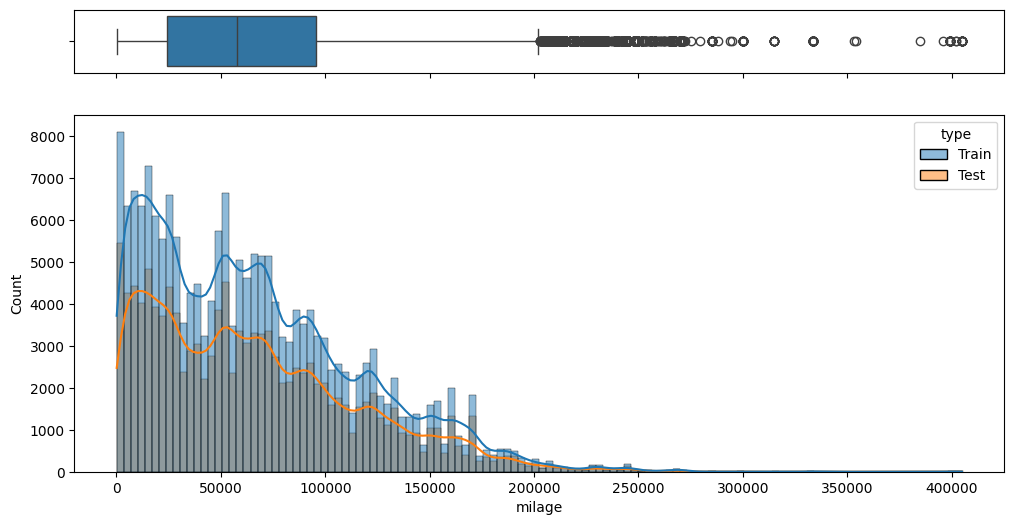

In [26]:
num_research(df_full, 'milage', hue='type', kde=True)

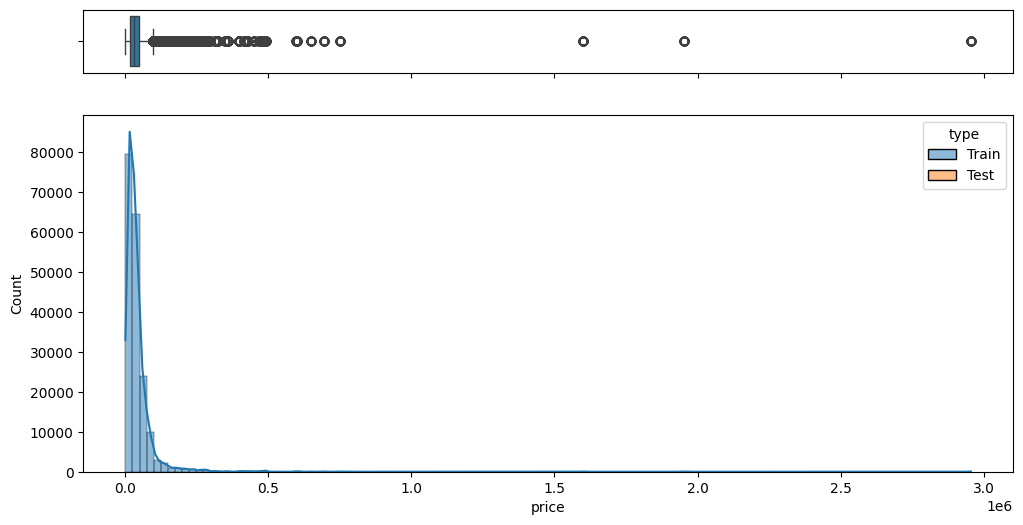

In [27]:
num_research(df_full, 'price', hue='type', kde=True)

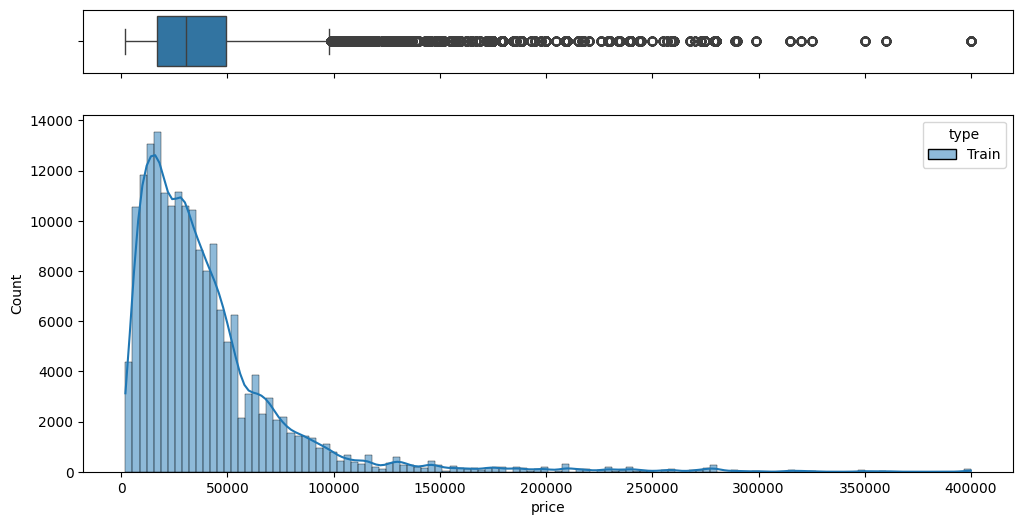

In [28]:
num_research(df_full.query('price < 400000'), 'price', hue='type', kde=True)

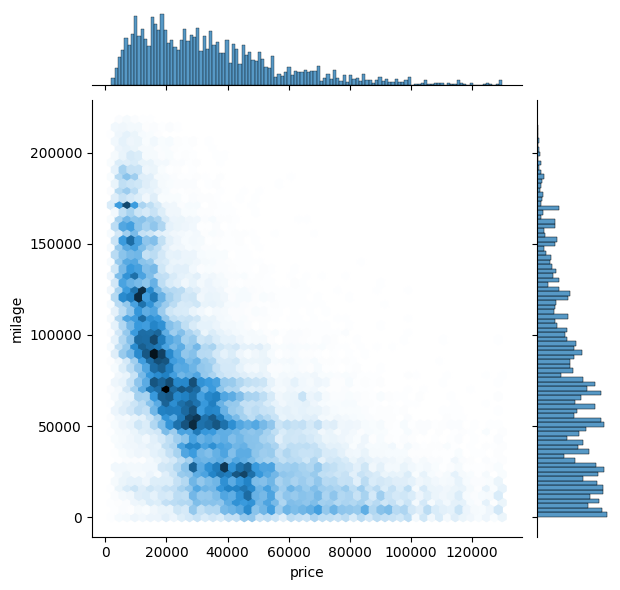

In [29]:
sns.jointplot(
    data=df_full.query('price < 130000 and milage < 220000'), 
    x="price", 
    y='milage', 
    kind='hex'
);

### Categorical

In [30]:
df_full.brand.value_counts().head(20)

brand
Ford             38353
Mercedes-Benz    32047
BMW              28314
Chevrolet        27033
Audi             18176
Porsche          17765
Land             15873
Toyota           14934
Lexus            14372
Jeep             10886
Cadillac          7733
RAM               7002
Nissan            6604
Tesla             6125
INFINITI          5399
GMC               5309
Dodge             5204
Mazda             4489
Kia               4247
Lincoln           4016
Name: count, dtype: int64

In [31]:
top_brands = pd.DataFrame(df_full.brand.value_counts()).reset_index()

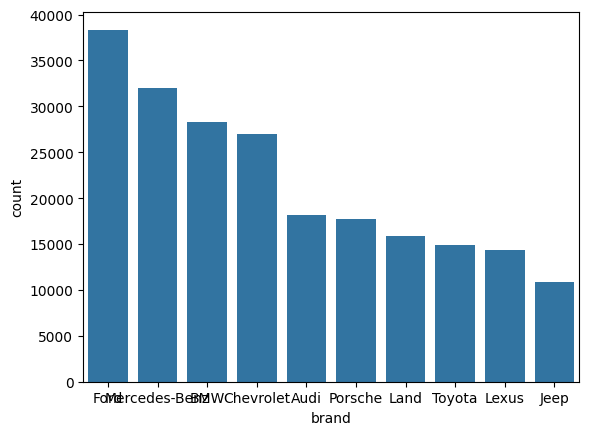

In [32]:
sns.barplot(data=top_brands.head(10), x='brand', y='count');

(0.0, 200000.0)

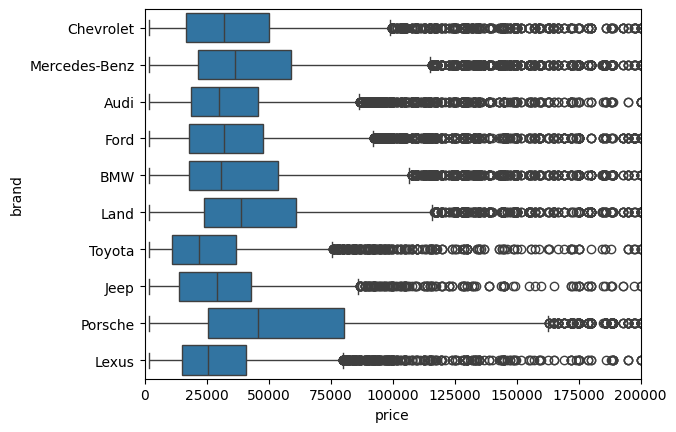

In [33]:
fig = sns.boxplot(
    data=df_full.loc[df_full['brand'].isin(top_brands.head(10).brand)], 
    x='price', 
    y='brand'
)
fig.set_xlim(0, 200000)

In [34]:
top_models = pd.DataFrame(df_full.model.value_counts(sort=True)).reset_index()
top_models

,model,count
0,F-150 XLT,4868
1,M3 Base,3641
2,Camaro 2SS,2820
3,M4 Base,2627
4,Mustang GT Premium,2464
...,...,...
1893,X5 xDrive40e,2
1894,Forte LX,2
1895,V60 T6 R-Design Platinum,2
1896,X5 3.0i,1


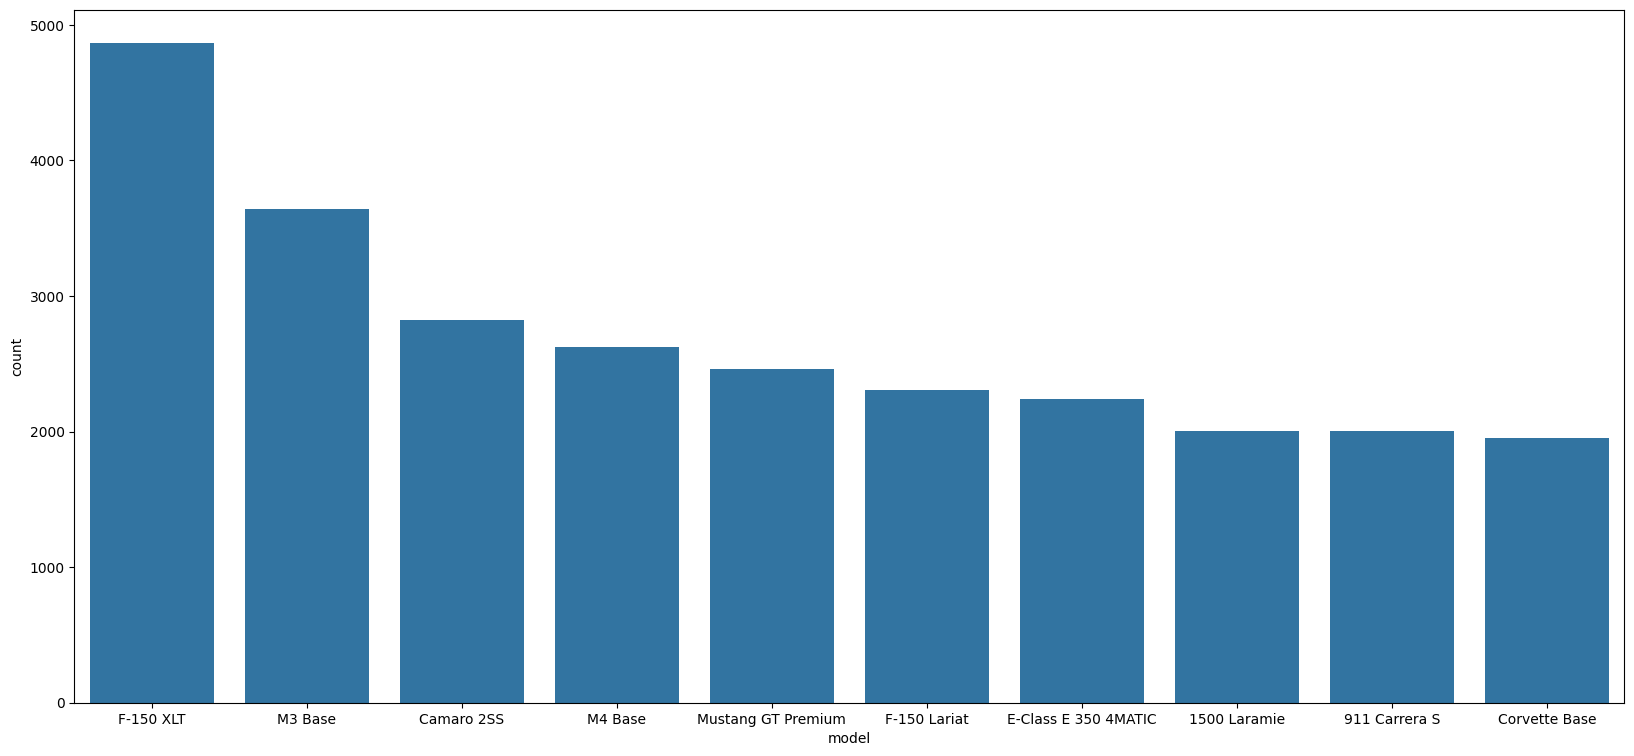

In [35]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.barplot(data=top_models.head(10), x='model', y='count')
plt.show()

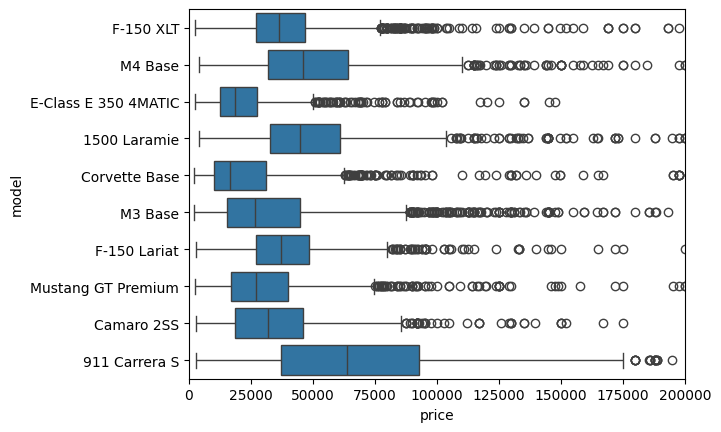

In [36]:
fig = sns.boxplot(
    data=df_full.loc[df_full['model'].isin(top_models.head(10).model)], 
    x='price', 
    y='model'
)
fig.set_xlim(0, 200000);

In [37]:
year_count = pd.DataFrame(
    df_full.pivot_table(index='model_year', values='price', aggfunc=['count', 'mean'])
    .sort_values('model_year', ascending=False)
)
year_count.head()

,count,mean
,price,price
model_year,,
2024,162,78006.067901
2023,8769,95707.912305
2022,15749,72732.327005
2021,18198,65893.857951
2020,15848,61556.784074


In [38]:
year_count = pd.DataFrame(
    df_full.model_year
    .value_counts()
).sort_values('model_year', ascending=False).reset_index()
year_count

,model_year,count
0,2024,277
1,2023,14552
2,2022,26163
3,2021,30234
4,2020,26565
5,2019,25393
6,2018,27559
7,2017,21208
8,2016,22758
9,2015,18925


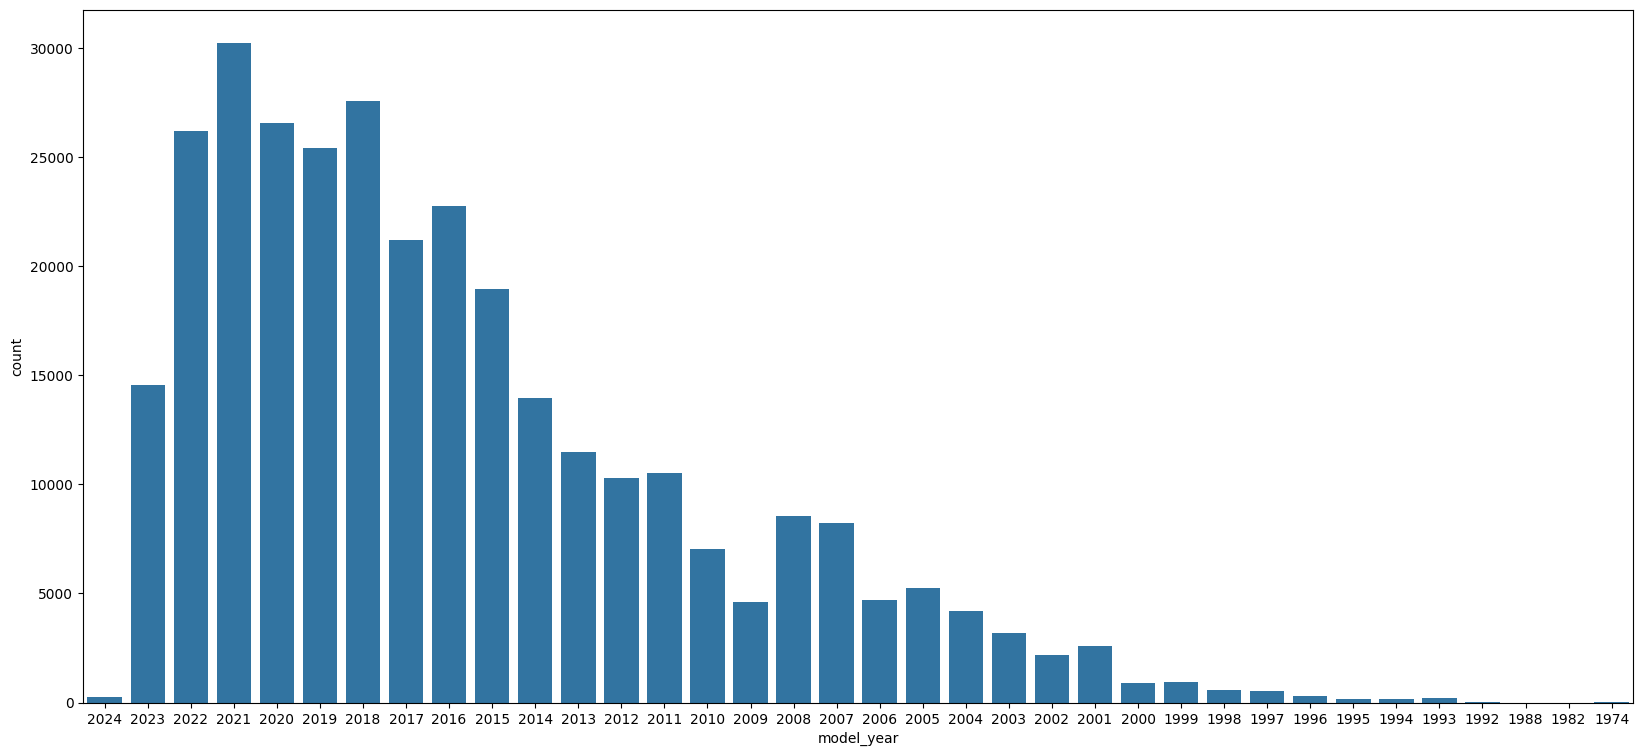

In [39]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.barplot(data=year_count, x='model_year', y='count')
plt.show()

In [40]:
year_price_mean = pd.DataFrame(
    df_full.pivot_table(index='model_year', values='price', aggfunc='mean')
    .sort_values('model_year', ascending=False)
)
year_price_mean.head()

,price
model_year,
2024,78006.067901
2023,95707.912305
2022,72732.327005
2021,65893.857951
2020,61556.784074


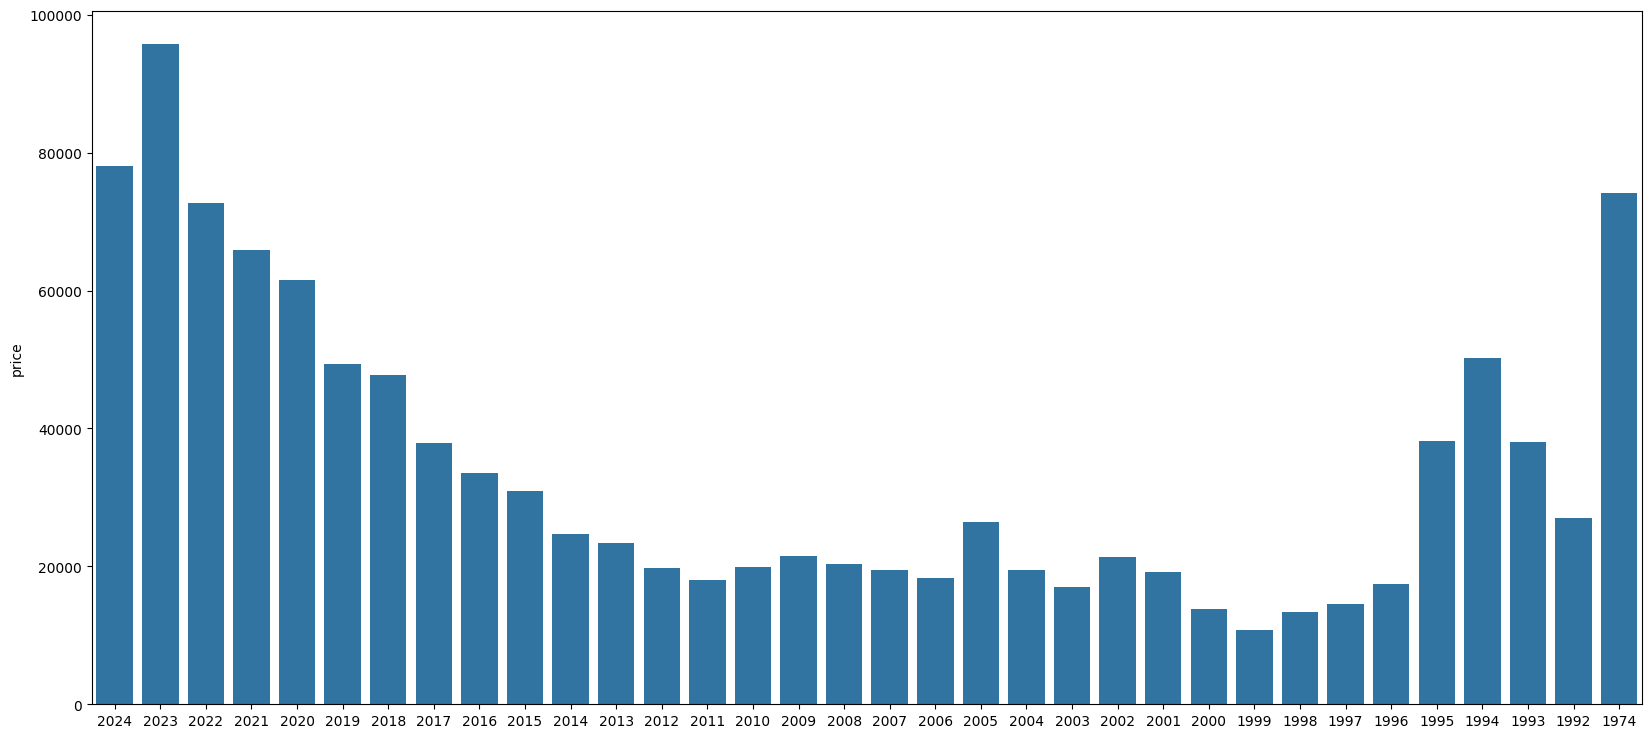

In [41]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.barplot(data=year_price_mean, x=year_price_mean.index.tolist(), y='price')
plt.show()

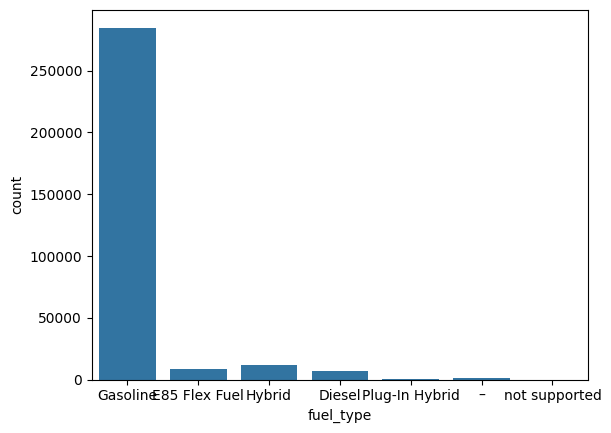

In [42]:
sns.countplot(data=df_full, x='fuel_type');

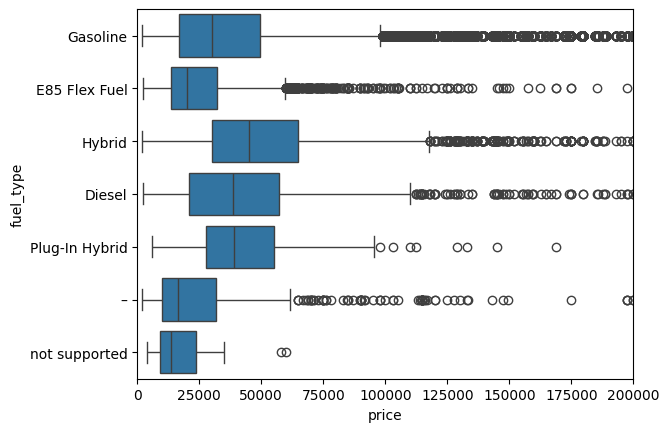

In [43]:
fig = sns.boxplot(
    data=df_full, 
    y='fuel_type', 
    x='price'
)
fig.set_xlim(0, 200000);

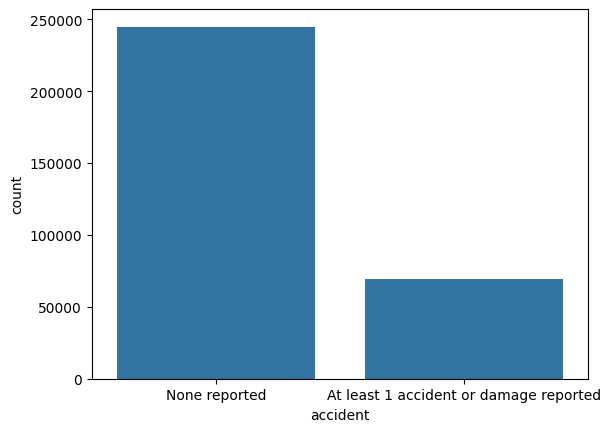

In [44]:
sns.countplot(data=df_full, x='accident');

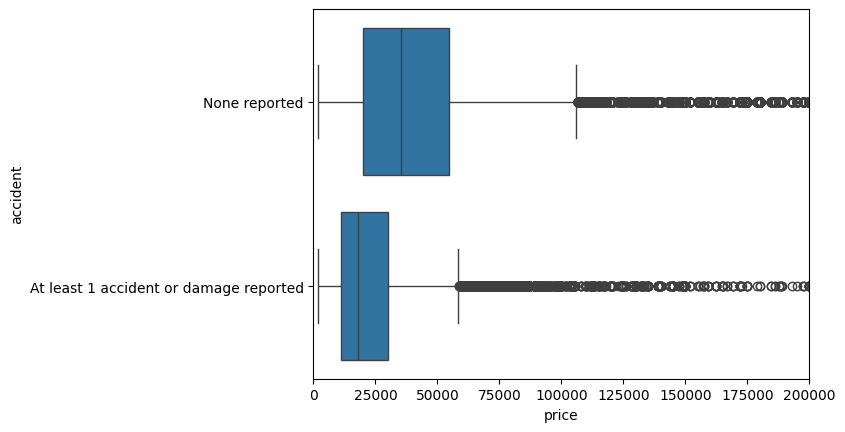

In [45]:
fig = sns.boxplot(
    data=df_full, 
    y='accident', 
    x='price'
)
fig.set_xlim(0, 200000);

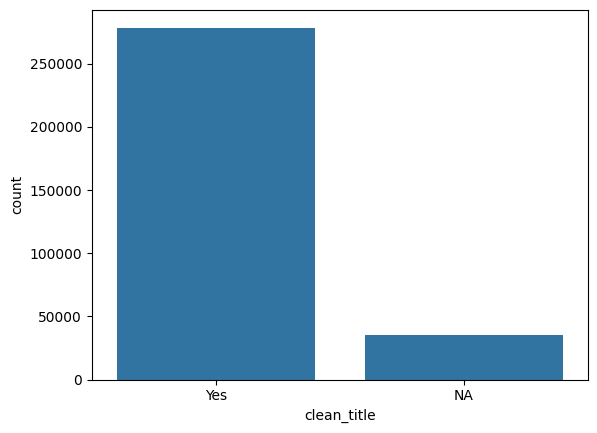

In [46]:
sns.countplot(data=df_full, x='clean_title');

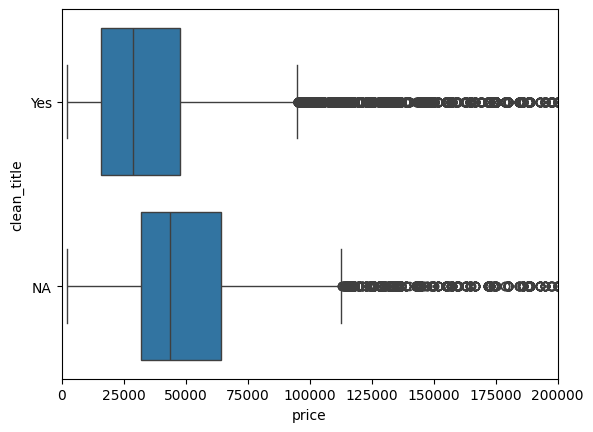

In [47]:
fig = sns.boxplot(
    data=df_full, 
    y='clean_title', 
    x='price'
)
fig.set_xlim(0, 200000);

In [48]:
top_ext_col = pd.DataFrame(df_full.ext_col.value_counts(sort=True)).reset_index()
top_ext_col

,ext_col,count
0,Black,81028
1,White,73040
2,Gray,42193
3,Silver,28343
4,Blue,24272
...,...,...
314,Granite Crystal Metallic Clearcoat,8
315,BLUE,7
316,Nautical Blue Pearl,7
317,Mango Tango Pearlcoat,5


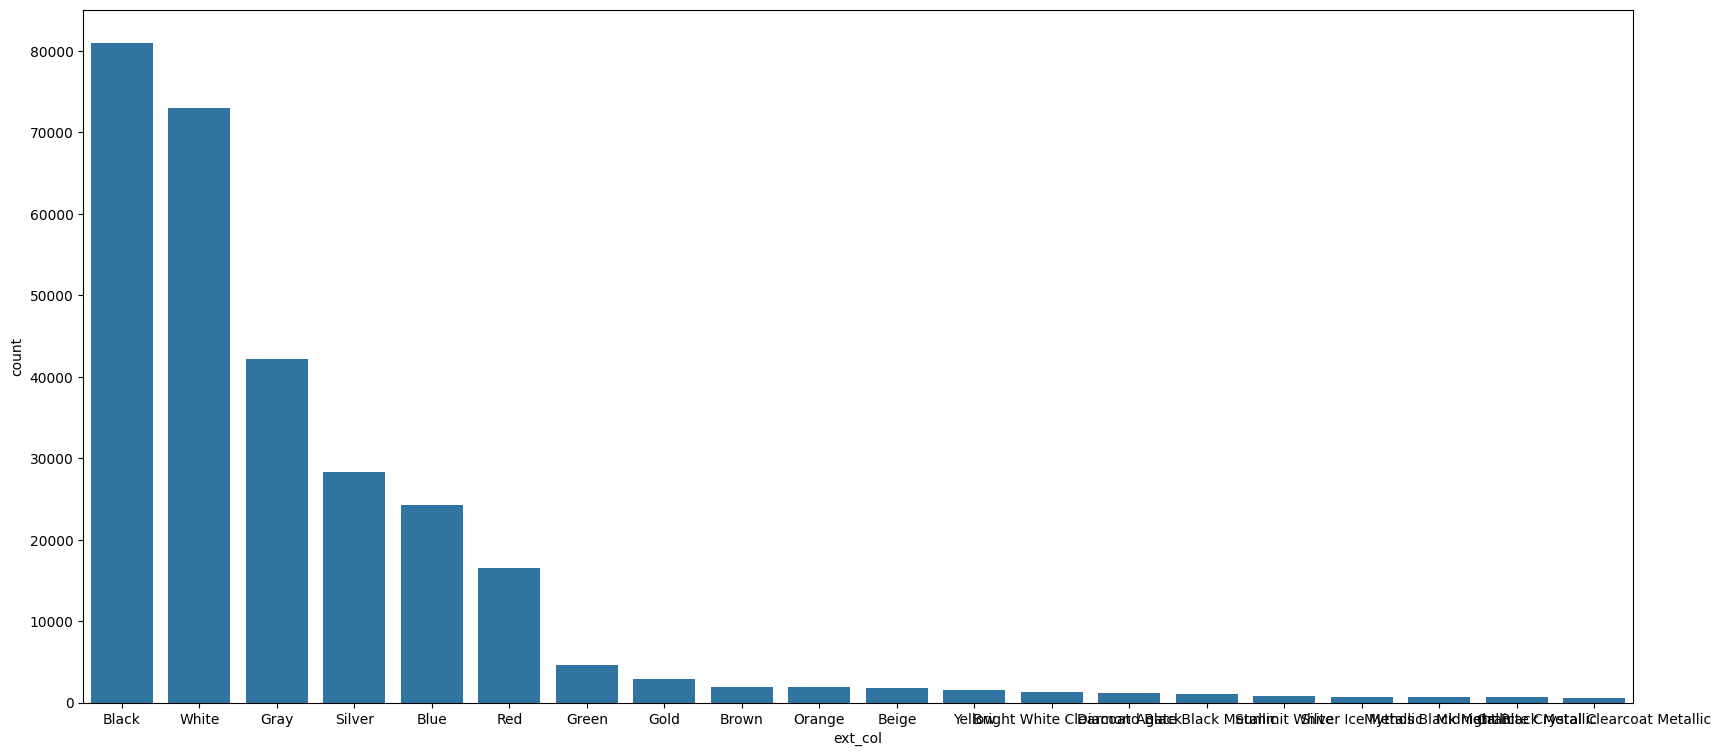

In [49]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.barplot(data=top_ext_col.head(20), x='ext_col', y='count')
plt.show()

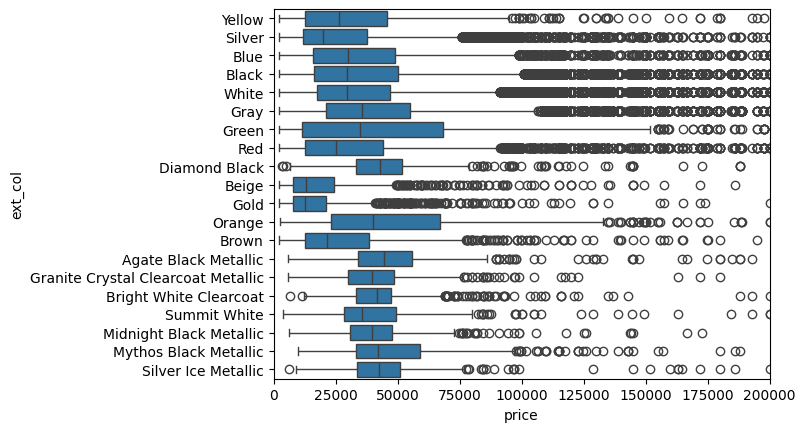

In [50]:
fig = sns.boxplot(
    data=df_full.loc[df_full['ext_col'].isin(top_ext_col.head(20).ext_col)], 
    x='price', 
    y='ext_col'
)
fig.set_xlim(0, 200000);

In [51]:
df_full.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,type
id,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Train
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Train
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Train
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Train
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Train


In [52]:
top_int_col = pd.DataFrame(df_full.int_col.value_counts(sort=True)).reset_index()
top_int_col

,int_col,count
0,Black,179287
1,Beige,40990
2,Gray,35381
3,Brown,9721
4,Red,8641
...,...,...
151,WHITE,14
152,Carbon Black,12
153,Bianco Polar,11
154,Cobalt Blue,9


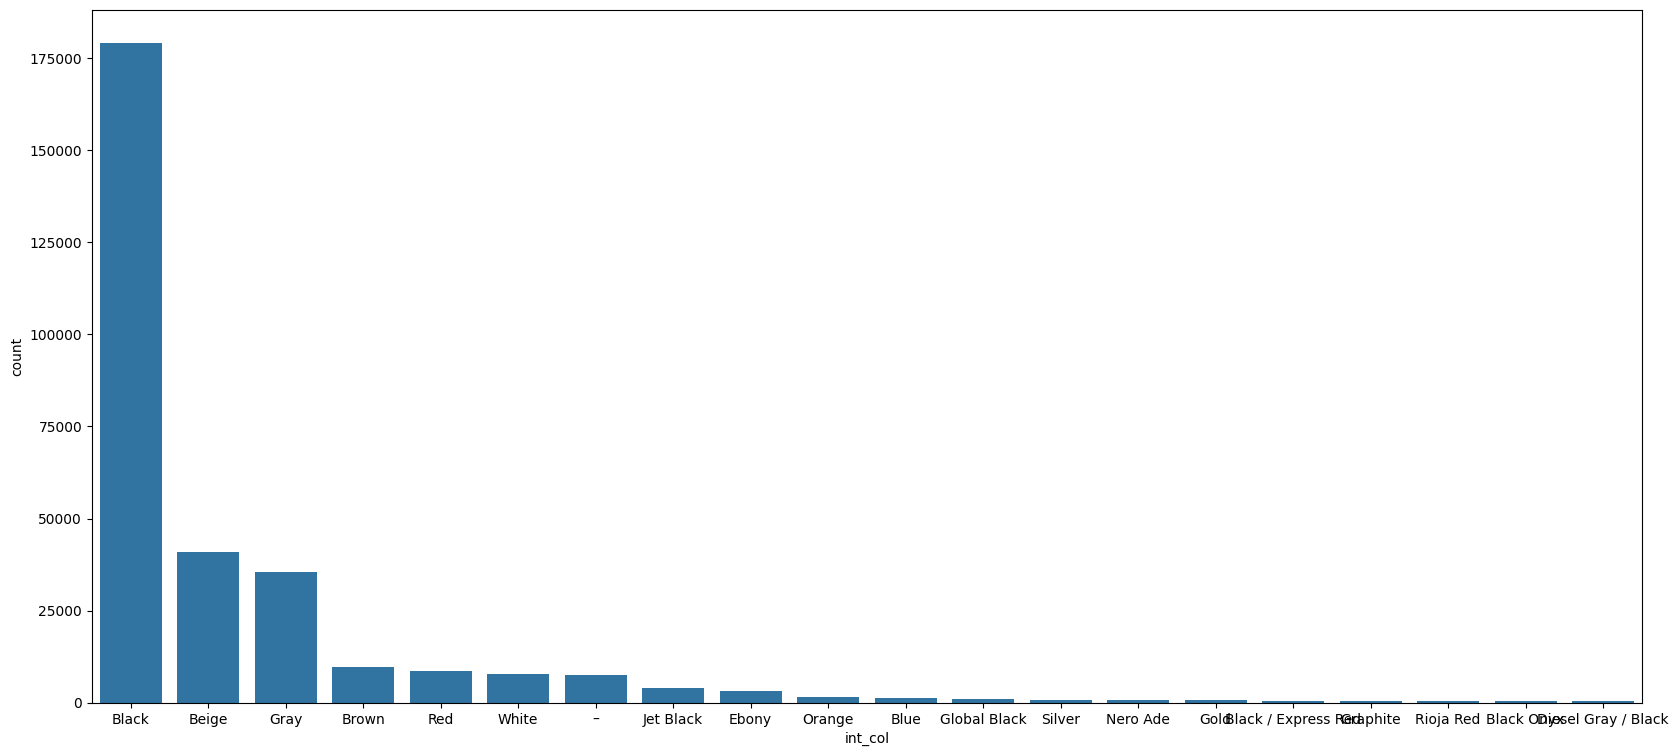

In [53]:
fig, ax = plt.subplots(figsize=(20, 9))
sns.barplot(data=top_int_col.head(20), x='int_col', y='count')
plt.show()

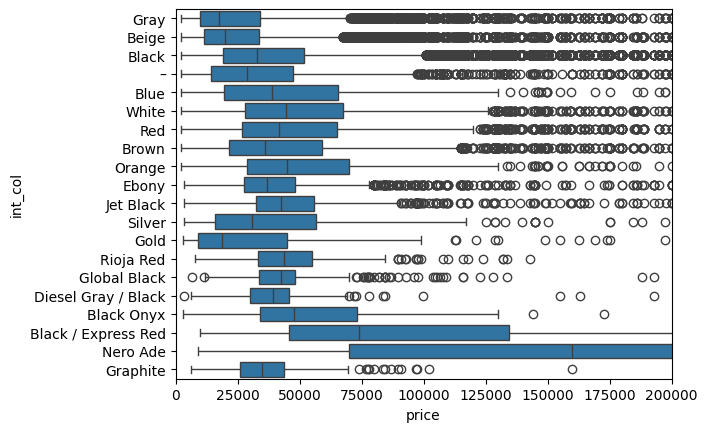

In [54]:
fig = sns.boxplot(
    data=df_full.loc[df_full['int_col'].isin(top_int_col.head(20).int_col)], 
    x='price', 
    y='int_col'
)
fig.set_xlim(0, 200000);

In [55]:
df_full.engine.value_counts().head(45)

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel                             5651
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                             4868
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             4694
2.0L I4 16V GDI DOHC Turbo                                               4513
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                            4090
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel                            4001
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             3689
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             3539
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                    3453
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                    3451
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel                            3216
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                            3167
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            

## Feature engineering

In [56]:
kbd = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')

In [57]:
df_full['milage_bins'] = kbd.fit_transform(df_full[['milage']])

In [58]:
kbd.bin_edges_

array([array([1.0000e+02, 1.5350e+04, 3.5248e+04, 5.7550e+04, 8.0500e+04,
              1.1700e+05, 4.0500e+05])                                   ],
      dtype=object)

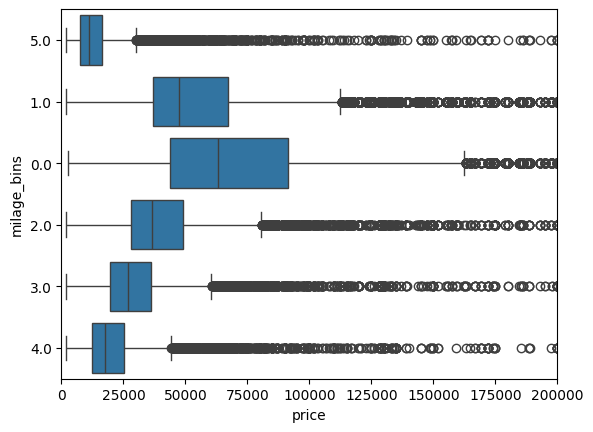

In [59]:
fig = sns.boxplot( 
    x=df_full['price'], 
    y=df_full['milage_bins'].astype('str')
)
fig.set_xlim(0, 200000);

In [60]:
df_full.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,type,milage_bins
id,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Train,5.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Train,5.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Train,5.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Train,1.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Train,0.0


In [215]:
df_full.transmission.value_counts()

transmission
A/T                                                   83036
8-Speed A/T                                           34586
Transmission w/Dual Shift Mode                        32079
6-Speed A/T                                           30105
6-Speed M/T                                           19863
7-Speed A/T                                           18498
Automatic                                             17866
8-Speed Automatic                                     13977
10-Speed A/T                                          13347
9-Speed A/T                                            6450
5-Speed A/T                                            5458
10-Speed Automatic                                     5268
6-Speed Automatic                                      4690
4-Speed A/T                                            4212
5-Speed M/T                                            4048
9-Speed Automatic                                      3878
CVT Transmission           

In [247]:
def transmission_specs(transmission):
    speed_num = 'n/s'
    transmission_type = 'n/s'
    other_spec = 'n/s'
    
    automatic = ['a/t', 'automatic', 'auto', 'at']
    manual = ['m/t', 'mt', 'manual']
    #other_spec = ['w/dual shift mode', 'overdrive', 'auto-shift']
    
    for x in automatic:
        if x in transmission.lower():
            transmission_type = 'a/t'
    for y in manual:
        if y in transmission.lower():
            transmission_type = 'm/t'
    
    speed = r'(\d+)-speed'
    match = re.search(speed, transmission.lower())
    if match:
        speed_num = int(match.group(1))
        
    if 'w/dual shift mode' in transmission.lower() or 'dct' in transmission.lower():
        other_spec = 'dct'
    elif 'overdrive' in transmission.lower():
        other_spec = 'overdrive'
    elif 'auto-shift'in transmission.lower():
        other_spec = 'auto-shift'
    
    return transmission_type, speed_num, other_spec

In [248]:
df_full[['transmission_type', 'speed_num', 'transmission_spec']] = df_full['transmission'].apply(lambda x: pd.Series(transmission_specs(x)))

In [263]:
df_full['speed_num'] = df_full['speed_num'].astype(str)

In [249]:
df_full.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,type,milage_bins,car_age,miles_per_year,base_ext_col,extension_ext_col,base_int_col,horse_power,engine_liters,cylinders_cnt,turbo,engine_type,injection,camshaft,valve_cnt,brand_cat,quality,transmission_type,speed_num,transmission_spec
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Train,5.0,17,213000,yellow,other,gray,172.0,1.6,4.0,No,N/S,NaN,NaN,8.0,mass_market,3,a/t,n/s,n/s
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Train,5.0,22,143250,silver,other,beige,252.0,3.9,8.0,No,N/S,NaN,NaN,16.0,premium,1,a/t,n/s,n/s
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Train,5.0,22,136731,blue,other,gray,320.0,5.3,8.0,No,N/S,NaN,NaN,16.0,budget,1,a/t,n/s,n/s
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Train,1.0,7,19500,black,other,black,420.0,5.0,8.0,No,N/S,NaN,NaN,16.0,premium,0,n/s,n/s,dct
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Train,0.0,3,7388,black,other,beige,208.0,2.0,4.0,No,N/S,NaN,NaN,8.0,premium,0,a/t,7,n/s


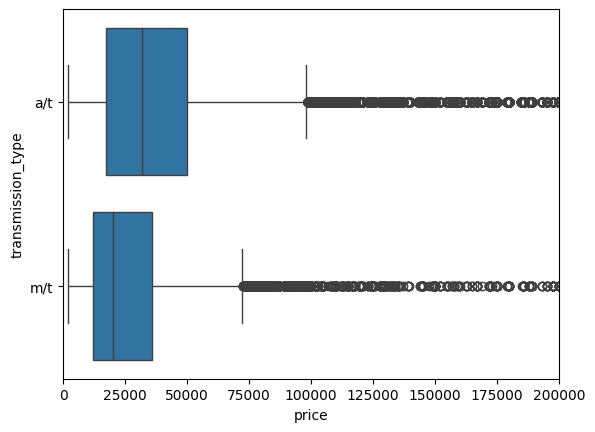

In [223]:
fig = sns.boxplot(
    data=df_full, 
    x='price', 
    y='transmission_type'
)
fig.set_xlim(0, 200000);

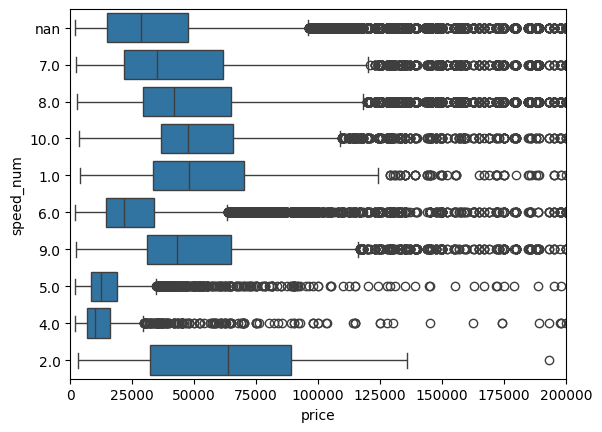

In [225]:
fig = sns.boxplot( 
    x=df_full['price'], 
    y=df_full['speed_num'].astype(str)
)
fig.set_xlim(0, 200000);

In [61]:
def car_age(year):
    return (2024 - int(year)) 

In [62]:
df_full['car_age'] = df_full['model_year'].apply(car_age)

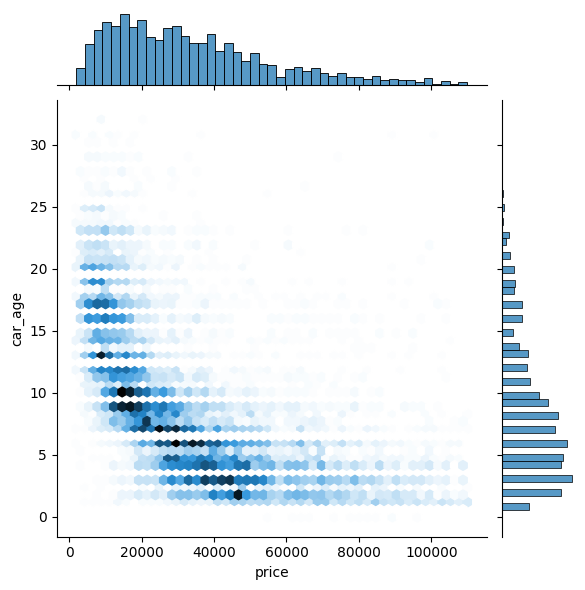

In [63]:
sns.jointplot(
    data=df_full.query('price < 110000 and car_age < 40').sample(15000), 
    x="price", 
    y='car_age', 
    kind='hex'
);

In [64]:
def miles_age(row):
    try:
        return (row['milage'] / row['car_age']).round()
    except:
        return row['milage']

In [65]:
df_full['miles_per_year'] = df_full.apply(miles_age, axis=1)

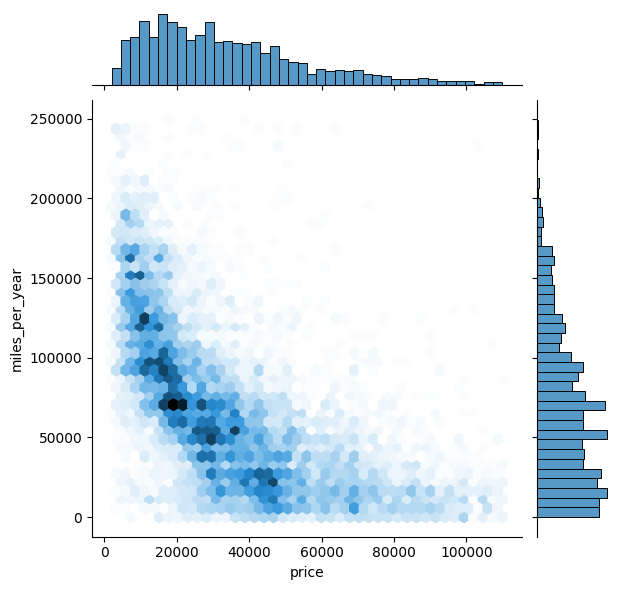

In [66]:
sns.jointplot(
    data=df_full.query('price < 110000 and miles_per_year < 250000').sample(12000), 
    x="price", 
    y='miles_per_year', 
    kind='hex'
);

In [67]:
base_ext_col = [
    'black', 
    'white', 
    'red', 
    'blue', 
    'silver', 
    'green', 
    'yellow', 
    'gray', 
    'gold', 
    'brown', 
    'orange', 
    'beige'
]

In [68]:
extension_ext_col = [
    'metallic', 'clearcoat', 
    'pearl', 'pearlcoat'
]

In [69]:
base_int_col = [
    'black', 
    'white', 
    'red', 
    'blue', 
    'silver', 
    'green', 
    'yellow', 
    'gray', 
    'gold', 
    'brown', 
    'orange', 
    'beige',
    'ebony'
]

In [70]:
def extract_color(color_series, base_colors):
    def extract_from_string(color_str):
        for color in base_colors:
            if color in color_str.lower():
                return color
            elif '/' in color_str.lower():
                return 'dual_color'
        return 'other'
    
    return color_series.apply(extract_from_string)

In [71]:
df_full['base_ext_col'] = extract_color(df_full['ext_col'], base_ext_col)

In [72]:
df_full['extension_ext_col'] = extract_color(df_full['ext_col'], extension_ext_col)

In [73]:
df_full['base_int_col'] = extract_color(df_full['int_col'], base_int_col)

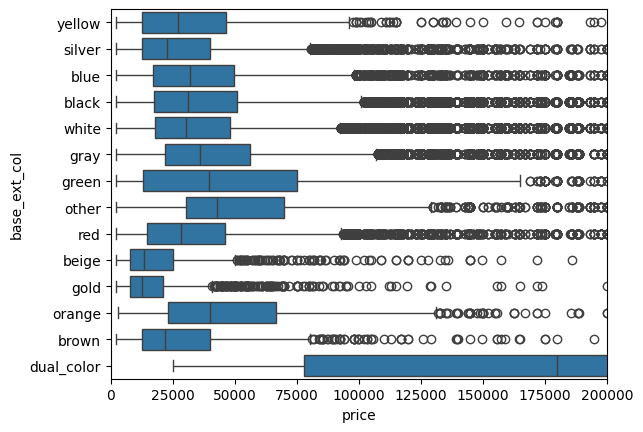

In [74]:
fig = sns.boxplot(
    data=df_full, 
    x='price', 
    y='base_ext_col'
)
fig.set_xlim(0, 200000);

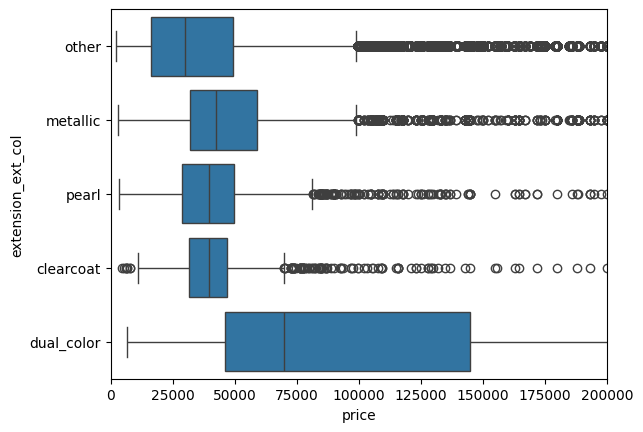

In [75]:
fig = sns.boxplot(
    data=df_full, 
    x='price', 
    y='extension_ext_col'
)
fig.set_xlim(0, 200000);

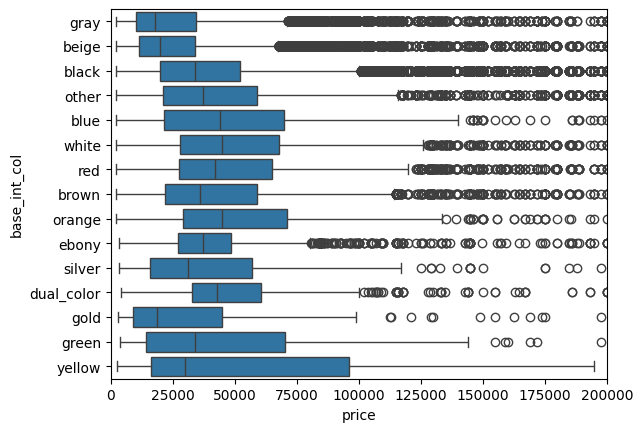

In [76]:
fig = sns.boxplot(
    data=df_full, 
    x='price', 
    y='base_int_col'
)
fig.set_xlim(0, 200000);

def extract_engine_specs(engine_spec_str):
    
    hp = []
    liters = []
    cylinder = []
    turbo = []
    
    for string in engine_spec_str:
        # Regular expression patterns for HP, L, and Cylinder
        hp_pattern = r'(\d+\.?\d*)HP'
        l_pattern = r'(\d+\.?\d*)L'
        l_1_pattern = r'(\d+\.?\d*)\s+Liter'
        cylinder_pattern = r'(\d+)\s+Cylinder'

    # Search for matches
        hp_match = re.search(hp_pattern, string)
        l_match = re.search(l_pattern, string)
        l_1_match = re.search(l_1_pattern, string)
        
        if 'I4' in string:
            cylinder_value = '4'  # I4 is 4 cylinders
        elif 'V6' in string:
            cylinder_value = '6'  # V6 is 6 cylinders
        elif 'V8' in string:
            cylinder_value = '8'  # V6 is 6 cylinders
        else:
            cylinder_match = re.search(cylinder_pattern, string)
            cylinder_value = cylinder_match.group(1).split()[0] if cylinder_match else None

    # Extracting values or setting to None if not found
        hp_value = hp_match.group(1) if hp_match else np.NaN
        if l_match:
            l_value = l_match.group(1)
        elif l_1_match:
            l_value = l_1_match.group(1)
        else:
            l_value = np.NaN
        
        hp.append(float(hp_value))
        liters.append(float(l_value))
        cylinder.append(cylinder_value)
        
    return hp, liters, cylinder

In [77]:
def extract_engine_specs(df, column_name):
    
    def extract_specs(spec_string):
        hp = np.NaN
        liters = np.NaN
        cylinders = np.NaN
        turbo = "No"
        engine_type = np.NaN
        fuel_type = np.NaN
        camshaft = np.NaN
        injection = np.NaN
        
        if 'dohc' in spec_string.lower():
            camshaft = 'dohc'
        elif 'ohv' in spec_string.lower():
            camshaft = 'ohv'
        elif 'sohc' in spec_string.lower():
            camshaft = 'sohc'
        elif 'ohc' in spec_string.lower():
            camshaft = 'ohc'
            
        if 'gdi' in spec_string.lower():
            injection = 'gdi'
        elif 'pdi' in spec_string.lower():
            injection = 'gdi'
        elif 'mpfi' in spec_string.lower():
            injection = 'mpfi'
        
        hp_match = re.search(r'(\d+\.?\d*)HP', spec_string)
        if hp_match:
            hp = float(hp_match.group(1))
        elif spec_string == '2.0L I4 16V GDI DOHC Turbo':
            hp = 270.0
        
        liters_match = re.search(r'(\d+\.?\d*)L', spec_string)
        liters_match_1 = re.search(r'(\d+\.?\d*)\s+Liter', spec_string)
        if liters_match:
            liters = float(liters_match.group(1))
        elif liters_match_1:
            liters = float(liters_match_1.group(1))
        else:
            liters = np.NaN
        
        cylinders_match = re.search(r'(\d+)\s*Cylinder', spec_string)
        if cylinders_match:
            cylinders = int(cylinders_match.group(1))
            if 'Straight' in spec_string or 'I' in spec_string:
                engine_type = "Inline"
            elif 'V' in spec_string:
                engine_type = "V"
        elif 'I4' in spec_string:
            cylinders = 4
            engine_type = 'Inline'
        elif 'V6' in spec_string:
            cylinders = 6
            engine_type = 'V'
        else:
            inline_match = re.search(r'Straight\s*(\d)', spec_string)
            if inline_match:
                cylinders = int(inline_match.group(1))
                engine_type = "Inline"
            else:
                v_match = re.search(r'V(\d)', spec_string)
                if v_match:
                    cylinders = int(v_match.group(1))
                    engine_type = "V"
        
        if 'Twin' in spec_string:
            turbo = "Twin"
        elif 'Turbo' in spec_string:
            turbo = 'Yes'
        else:
            turbo = 'No'
        
        #fuel_match = re.search(r'(\bGasoline\b|\bDiesel\b|\bElectric\b|\bHybrid\b|\bFlex\b)', spec_string)
        #if fuel_match:
            #fuel_type_engine = fuel_match.group(1)
        
        return pd.Series([hp, liters, cylinders, turbo, engine_type, injection, camshaft])#, fuel_type])

    engine_specs = df[column_name].apply(extract_specs)
    
    df[['horse_power', 'engine_liters', 'cylinders_cnt', 'turbo', 'engine_type', 'injection', 'camshaft']] = engine_specs #, 'fuel_type_engine']] = engine_specs
    return df

In [78]:
df_full = extract_engine_specs(df_full, 'engine')
df_full.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,type,milage_bins,car_age,miles_per_year,base_ext_col,extension_ext_col,base_int_col,horse_power,engine_liters,cylinders_cnt,turbo,engine_type,injection,camshaft
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Train,5.0,17,213000,yellow,other,gray,172.0,1.6,4.0,No,NaN,NaN,NaN
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Train,5.0,22,143250,silver,other,beige,252.0,3.9,8.0,No,NaN,NaN,NaN
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Train,5.0,22,136731,blue,other,gray,320.0,5.3,8.0,No,NaN,NaN,NaN
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Train,1.0,7,19500,black,other,black,420.0,5.0,8.0,No,NaN,NaN,NaN
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Train,0.0,3,7388,black,other,beige,208.0,2.0,4.0,No,NaN,NaN,NaN


In [79]:
def valve_cnt(row):
    valve_match = re.search(r'\b(\d+)V\b', row['engine'])
    if valve_match:
        valve_cnt = int(valve_match.group(1))
    else:
        valve_cnt = row['cylinders_cnt'] * 2
    
    return valve_cnt

In [80]:
df_full['valve_cnt'] = df_full.apply(valve_cnt, axis=1)

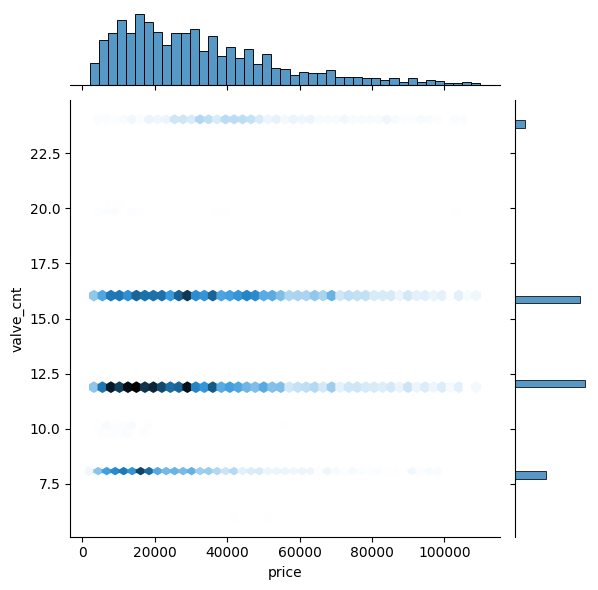

In [81]:
sns.jointplot(
    data=df_full.query('price < 110000 and valve_cnt < 30').sample(12000), 
    x="price", 
    y='valve_cnt', 
    kind='hex'
);

In [82]:
df_full['model'].value_counts().head(15)

model
F-150 XLT                  4868
M3 Base                    3641
Camaro 2SS                 2820
M4 Base                    2627
Mustang GT Premium         2464
F-150 Lariat               2304
E-Class E 350 4MATIC       2239
1500 Laramie               2006
911 Carrera S              2004
Corvette Base              1949
GX 460 Base                1912
E-Class E 350              1896
911 Carrera                1866
Corvette Stingray w/2LT    1827
Explorer XLT               1797
Name: count, dtype: int64

In [83]:
df_full['model'].value_counts().head(15)

model
F-150 XLT                  4868
M3 Base                    3641
Camaro 2SS                 2820
M4 Base                    2627
Mustang GT Premium         2464
F-150 Lariat               2304
E-Class E 350 4MATIC       2239
1500 Laramie               2006
911 Carrera S              2004
Corvette Base              1949
GX 460 Base                1912
E-Class E 350              1896
911 Carrera                1866
Corvette Stingray w/2LT    1827
Explorer XLT               1797
Name: count, dtype: int64

In [84]:
df_full.isna().sum()

brand                     0
model                     0
model_year                0
milage                    0
fuel_type                 0
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident                  0
clean_title               0
price                125690
type                      0
milage_bins               0
car_age                   0
miles_per_year            0
base_ext_col              0
extension_ext_col         0
base_int_col              0
horse_power           50927
engine_liters         11208
cylinders_cnt         26184
turbo                     0
engine_type          175124
injection            275981
camshaft             274089
valve_cnt             23615
dtype: int64

In [85]:
df_full['engine_type'] = df_full.engine_type.fillna('N/S')

In [86]:
df_full.engine.value_counts().head(55)

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel                             5651
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                             4868
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             4694
2.0L I4 16V GDI DOHC Turbo                                               4513
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                            4090
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel                            4001
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             3689
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                             3539
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                    3453
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                    3451
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel                            3216
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                            3167
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            

In [87]:
df_full.loc[df_full['horse_power'].isna()]['engine'].value_counts()

engine
3.5L V6 24V PDI DOHC Twin Turbo        3100
3.6L V6 24V MPFI DOHC                  2523
5.7L V8 16V MPFI OHV                   2505
4.0L V8 32V GDI DOHC Twin Turbo        2495
3.6L V6 24V GDI DOHC                   2072
                                       ... 
3.0L V6 Cylinder Engine Diesel Fuel       8
4.4 Liter GDI DOHC Twin Turbo             8
1.8 Liter                                 7
1.6L I4 16V GDI DOHC                      6
3.8L V6 12V MPFI OHV                      5
Name: count, Length: 187, dtype: int64

In [88]:
df_full.loc[df_full['horse_power'].isna()].groupby('engine').engine.agg('count')

engine
1.2L I3 12V GDI DOHC Turbo                            39
1.3L I3 12V GDI DOHC Turbo                            99
1.3L I3 12V MPFI DOHC Turbo                           13
1.4L I4 16V GDI DOHC Turbo                            21
1.5 Liter Turbo                                       17
                                                    ... 
Intercooled Turbo Premium Unleaded I-4 2.0 L/122      66
Standard Range Battery                                53
V6                                                   166
V8                                                    48
–                                                   1542
Name: engine, Length: 187, dtype: int64

In [89]:
df_full.loc[df_full['horse_power'].isna()]\
.groupby('engine')\
.agg({'model':lambda x: x.mode(), 'brand':'count', 'model_year':lambda x: x.mode()})\
.reset_index()\
.sort_values('brand', ascending=False)\
.head(15)

,engine,model,brand,model_year
95,3.5L V6 24V PDI DOHC Twin Turbo,F-150 XLT,3100,2021
101,3.6L V6 24V MPFI DOHC,Grand Cherokee L Limited,2523,2022
149,5.7L V8 16V MPFI OHV,1500 Laramie,2505,2022
120,4.0L V8 32V GDI DOHC Twin Turbo,AMG G 63 Base,2495,2022
100,3.6L V6 24V GDI DOHC,Enclave Avenir,2072,2021
23,2.0 Liter Turbo,GLC 300 GLC 300,1912,2021
141,5.3L V8 16V GDI OHV,Suburban Premier,1710,2021
186,–,Challenger R/T Scat Pack,1542,1993
46,2.5L I4 16V GDI DOHC,CX-30 Premium Package,1494,2021
65,3.0 Liter Turbo,Macan S,1417,2020


In [90]:
#df_full.loc[df_full.model == 'Grand Cherokee L Limited'].horse_power.fillna(290, inplace=True)# = df_full.query('model == "Grand Cherokee L Limited"').horse_power.fillna(290)
#df_full.loc[df_full.model == '1500 Laramie'] = df_full.query('model == "1500 Laramie"').horse_power.fillna(305)
#df_full.loc[df_full.model == 'AMG G 63 Base'] = df_full.query('model == "AMG G 63 Base"').horse_power.fillna(550)
#df_full.loc[df_full.model == 'Enclave Avenir'] = df_full.query('model == "Enclave Avenir"').horse_power.fillna(310)

def hp_fillna(df, model, horse_power):
    df.loc[
        (df['horse_power'].isna()) &
        (df['model'] == model),
        ['horse_power']
    ] = horse_power

    return df

In [91]:
df_full = hp_fillna(df_full, 'Grand Cherokee L Limited', 290)
df_full = hp_fillna(df_full, '1500 Laramie', 305)
df_full = hp_fillna(df_full, 'AMG G 63 Base', 550)
df_full = hp_fillna(df_full, 'Enclave Avenir', 310)

In [92]:
df_full.query('engine == "3.5L V6 24V PDI DOHC Twin Turbo"')['model'].value_counts()

model
F-150 XLT                984
Expedition Timberline    310
Expedition Limited       309
Expedition Platinum      280
F-150 Raptor             207
                        ... 
IS 250 Base                1
G37 x                      1
Tundra Limited             1
F-250 XLT                  1
MDX Technology             1
Name: count, Length: 125, dtype: int64

In [93]:
df_full.query('engine == "3.5L V6 24V PDI DOHC Twin Turbo"')['model'].value_counts()

model
F-150 XLT                984
Expedition Timberline    310
Expedition Limited       309
Expedition Platinum      280
F-150 Raptor             207
                        ... 
IS 250 Base                1
G37 x                      1
Tundra Limited             1
F-250 XLT                  1
MDX Technology             1
Name: count, Length: 125, dtype: int64

In [94]:
def hp_ford(df):
    
    engine = "3.5L V6 24V PDI DOHC Twin Turbo"
    model = "F-150 XLT"
    
    df.loc[
        (df['engine'] == engine) &
        (df['model'] == model) &
        ((df['model_year'] == "2019") | (df['model_year'] == "2020")),
        ['horse_power']
    ] = 375

    df.loc[
        (df['engine'] == engine) &
        (df['model'] == model) &
        ((df['model_year'] == "2021") | (df['model_year'] == "2022")),
        ['horse_power']
    ] = 400
    
    df.loc[
        (df['engine'] == engine) &
        (df['model'] == model) &
        ((df['model_year'] == "2021") | (df['model_year'] == "2022")),
        ['horse_power']
    ] = 440
    
    
    return df

In [95]:
df_full = hp_ford(df_full)

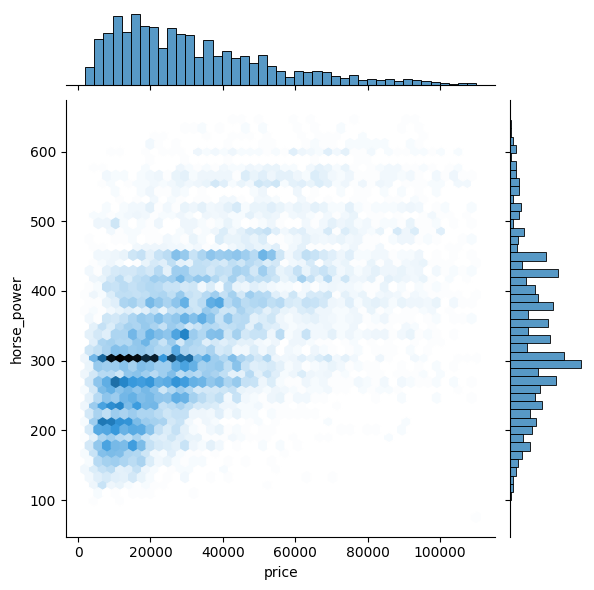

In [96]:
sns.jointplot(
    data=df_full.query('price < 110000 and horse_power < 650').sample(12000), 
    x="price", 
    y='horse_power', 
    kind='hex'
);

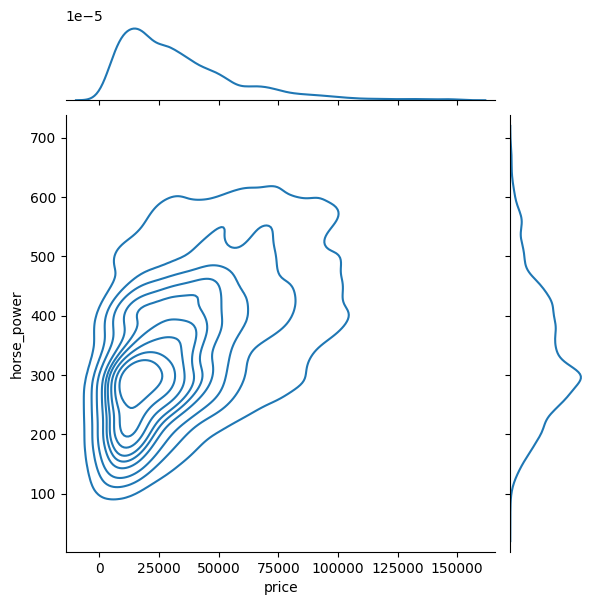

In [97]:
sns.jointplot(
    data=df_full.query('price < 150000 and horse_power < 700').sample(10000), 
    x="price", 
    y='horse_power', 
    kind='kde'
);

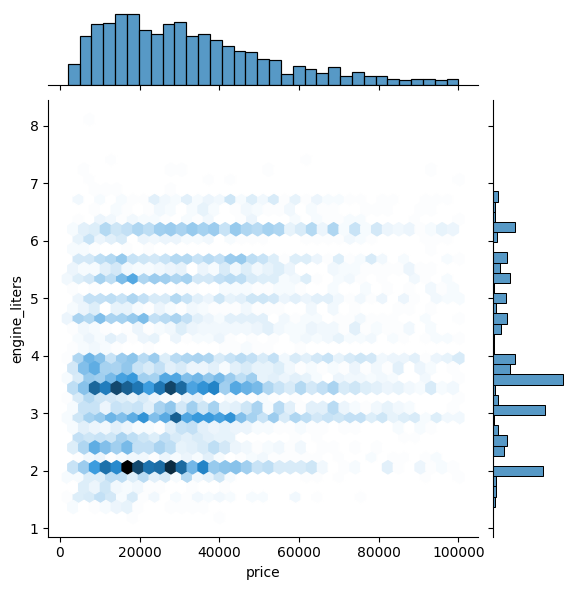

In [98]:
sns.jointplot(
    data=df_full.query('price < 100000').sample(7000), 
    x="price", 
    y='engine_liters', 
    kind='hex'
);

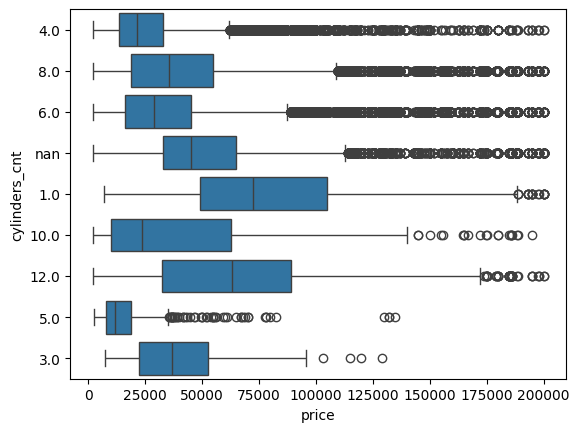

In [99]:
sns.boxplot(data=df_full.query('price < 200000'), x='price', y=df_full['cylinders_cnt'].astype('str'));

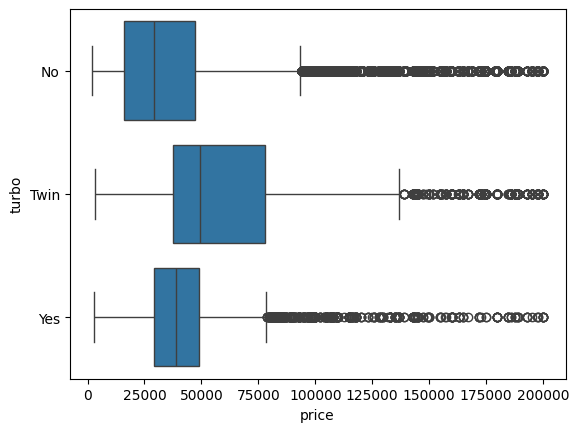

In [100]:
sns.boxplot(data=df_full.query('price < 200000'), x='price', y='turbo');

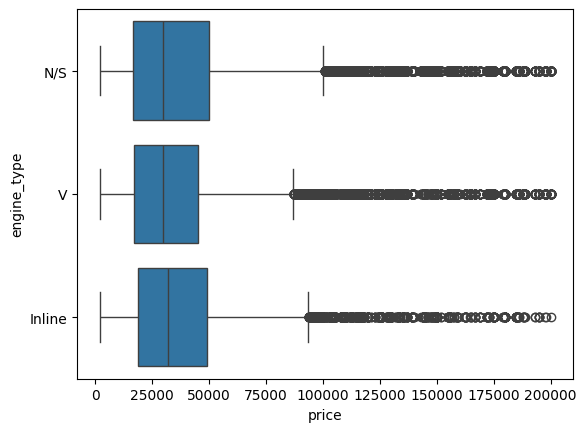

In [101]:
sns.boxplot(data=df_full.query('price < 200000'), x='price', y='engine_type');

In [102]:
supreme_lux = ['bentley', 'lamborghini', 'ferrari', 'mclaren', 'maybach', 'bugatti', 'rolls-royce', 'koenigsegg']
aspirat_lux = ['amg', 'porsche', 'm', 'maserati', 'aston martin', 'lotus', 'aston', 'karma']
premium = [
    'jaguar', 'mercedes-benz', 
    'lexus', 'genesis', 
    'range rover', 'alpina', 'bmw', 
    'cadillac', 'tesla', 'audi', 
    'land', 'volvo', 'infiniti', 'alfa', 'acura', 'lincoln', 'rivian', 'polestar', 'lucid'
]
mass_market = [
    'renault', 'volkswagen', 'toyota', 
    'nissan', 'fiat', 
    'kia', 'citroen', 'honda', 'ford', 'dodge', 
    'jeep', 'mini', 'ram', 'subaru', 'mercury', 'hummer', 'scion', 'plymouth', 'smart'
]
budget = [
    'changan', 'chevrolet', 'geely', 'seat', 'dacia', 
    'hyundai', 'skoda', 'gmc', 'mitsubishi', 'mazda', 
    'chrysler', 'suzuki', 'buick', 'pontiac', 'saab', 'saturn'
]

In [103]:
def brand_cat(df):
    category_map = {
        **{brand: 'supreme_lux' for brand in supreme_lux},
        **{brand: 'aspirat_lux' for brand in aspirat_lux},
        **{brand: 'premium' for brand in premium},
        **{brand: 'mass_market' for brand in mass_market},
        **{brand: 'budget' for brand in budget}
    }

    df['brand_cat'] = df['brand'].str.lower().map(category_map).fillna(np.NaN)
    
    return df

In [104]:
df_full = brand_cat(df_full)

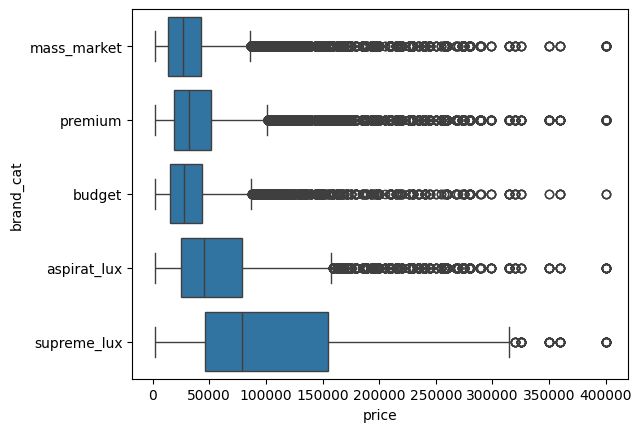

In [105]:
sns.boxplot(data=df_full.query('price < 400000'), x='price', y='brand_cat');

In [106]:
df_full.loc[df_full['brand_cat'].isna(), 'brand'].value_counts()

Series([], Name: count, dtype: int64)

In [107]:
df_full.isna().sum()

brand                     0
model                     0
model_year                0
milage                    0
fuel_type                 0
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident                  0
clean_title               0
price                125690
type                      0
milage_bins               0
car_age                   0
miles_per_year            0
base_ext_col              0
extension_ext_col         0
base_int_col              0
horse_power           47033
engine_liters         11208
cylinders_cnt         26184
turbo                     0
engine_type               0
injection            275981
camshaft             274089
valve_cnt             23615
brand_cat                 0
dtype: int64

### Clustering features

In [108]:
k_means = KMeans(n_clusters=5)

In [109]:
ordinal_enc = OrdinalEncoder()

In [110]:
df_full['clean_ord'] = ordinal_enc.fit_transform(df_full[['clean_title']])

In [111]:
df_full['accident_ord'] = ordinal_enc.fit_transform(df_full[['accident']])
df_full['brand_cat_ord'] = ordinal_enc.fit_transform(df_full[['brand_cat']])

In [112]:
k_means.fit(df_full[['car_age', 'milage', 'clean_ord', 'accident_ord', 'brand_cat_ord']])

KMeans(n_clusters=5)

In [113]:
k_means.labels_

array([3, 1, 1, ..., 2, 1, 2], dtype=int32)

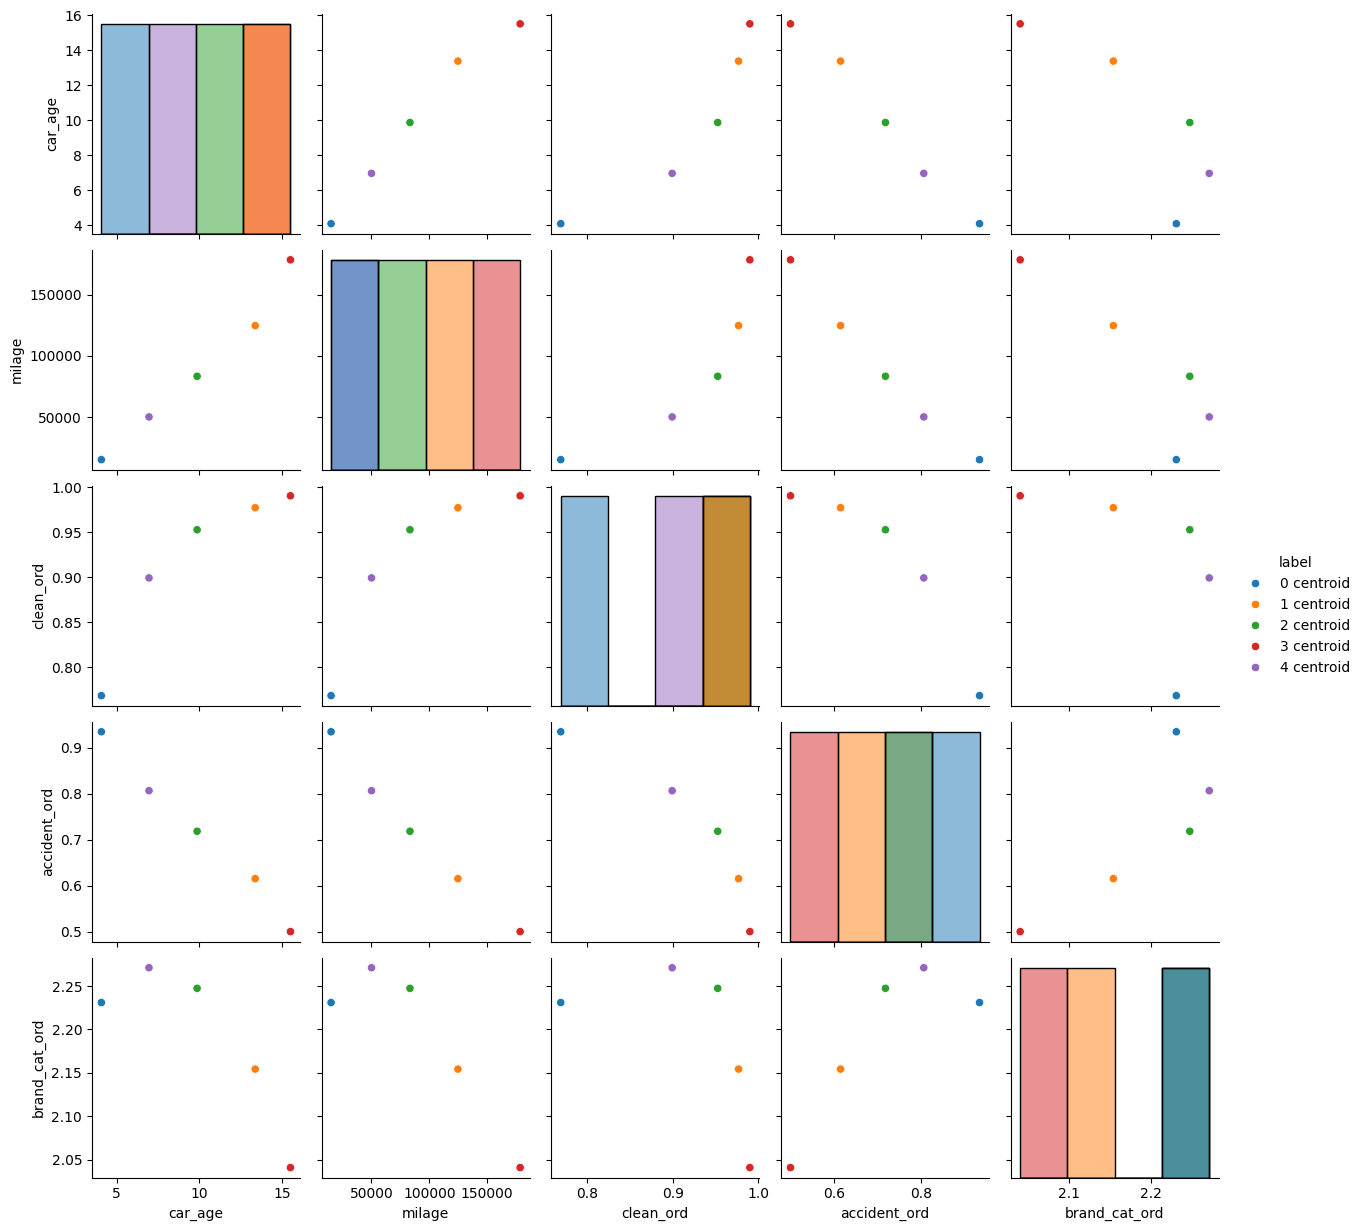

In [114]:
centroids = pd.DataFrame(k_means.cluster_centers_, columns=df_full[['car_age', 'milage', 'clean_ord', 'accident_ord', 'brand_cat_ord']].columns)
# Добавление столбца с номером кластера
df_full['label'] = k_means.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid', '4 centroid']
# Сброс индекса понадобится дальше
df_all = pd.concat([df_full[['car_age', 'milage', 'clean_ord', 'accident_ord', 'brand_cat_ord']], centroids], ignore_index=True)

# Построение графика
sns.pairplot(df_all, hue='label', diag_kind='hist') 

In [115]:
df_full = df_full.drop(['clean_ord', 'accident_ord', 'brand_cat_ord', 'label'], axis=1)

df_full['quality'] = k_means.labels_.astype(int)

In [116]:
corr_matrix = df_full.drop('model', axis=1).query('price < 400000')\
                .sample(3500)\
                .phik_matrix(interval_cols=['milage', 'price', 'horse_power', 'engine_liters', 'cylinders_cnt', 'car_age', 'miles_per_year'])

/opt/conda/lib/python3.10/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable type for analysis 1. Dropping this column
  warnings.warn(


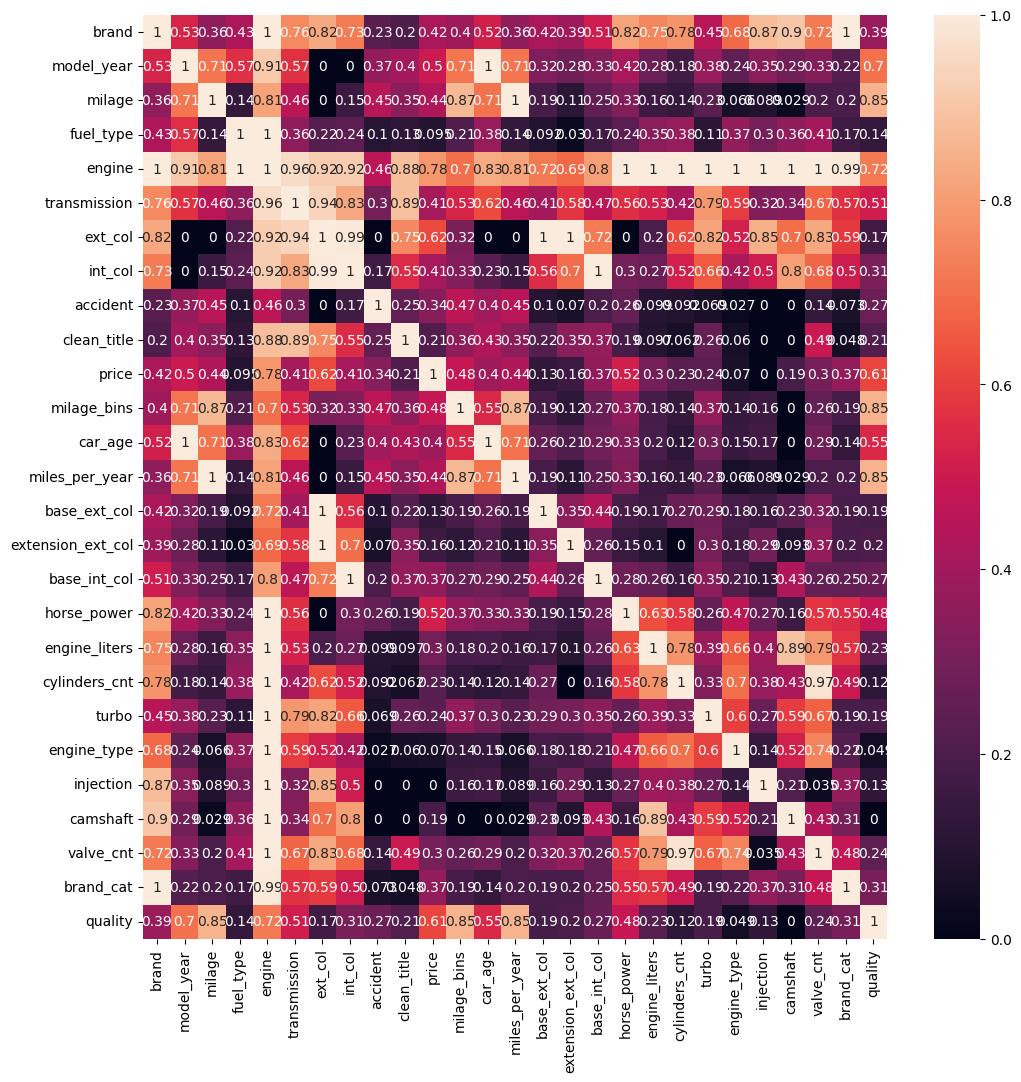

In [117]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True)
plt.show();

## Pipeline

In [264]:
train = df_full.loc[df_full['price'].isna() == False]
X_test = df_full.loc[df_full['price'].isna()]

train.shape

(188533, 32)

In [265]:
X_train = train.drop(['price', 'engine', 'model', 'type'], axis=1)
y_train = train['price']

In [266]:
train_samp = train.sample(25000)

X_train_samp = train_samp.drop(['price', 'engine', 'model', 'type'], axis=1)
y_train_samp = train_samp['price']

In [267]:
X_train.head()

,brand,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,milage_bins,car_age,miles_per_year,base_ext_col,extension_ext_col,base_int_col,horse_power,engine_liters,cylinders_cnt,turbo,engine_type,injection,camshaft,valve_cnt,brand_cat,quality,transmission_type,speed_num,transmission_spec
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,MINI,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,5.0,17,213000,yellow,other,gray,172.0,1.6,4.0,No,N/S,NaN,NaN,8.0,mass_market,3,a/t,n/s,n/s
1,Lincoln,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,5.0,22,143250,silver,other,beige,252.0,3.9,8.0,No,N/S,NaN,NaN,16.0,premium,1,a/t,n/s,n/s
2,Chevrolet,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,5.0,22,136731,blue,other,gray,320.0,5.3,8.0,No,N/S,NaN,NaN,16.0,budget,1,a/t,n/s,n/s
3,Genesis,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,1.0,7,19500,black,other,black,420.0,5.0,8.0,No,N/S,NaN,NaN,16.0,premium,0,n/s,n/s,dct
4,Mercedes-Benz,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,0.0,3,7388,black,other,beige,208.0,2.0,4.0,No,N/S,NaN,NaN,8.0,premium,0,a/t,7,n/s


In [268]:
X_train.brand_cat.value_counts()

brand_cat
premium        86007
mass_market    60283
budget         27248
aspirat_lux    11858
supreme_lux     3137
Name: count, dtype: int64

In [269]:
num_cols = ['milage', 'horse_power', 'car_age', 'engine_liters', 'miles_per_year']
cat_cols = [
    'brand', 
    #'brand_cat', 
    'model_year', 
    'fuel_type', 
    'transmission', 
    'ext_col', 
    'int_col', 
    'base_ext_col', 
    'cylinders_cnt',
    'injection',
    'camshaft',
    'valve_cnt',
    #'milage_bins',
    'extension_ext_col',
    'base_int_col',
    'speed_num',
    'transmission_spec'
]
ord_cols = ['brand_cat']
bin_cols = [
    'accident', 
    'clean_title', 
    'turbo', 
    'engine_type',
    'transmission_type'
]

In [270]:
bin_pipe =  Pipeline(
    [
        #('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('bin', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ]
)

In [271]:
cat_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('cat', TargetEncoder(random_state=RANDOM_STATE, target_type='continuous'))
    ]
)

In [272]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

In [273]:
ord_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='error', max_categories=5,
                           categories=[['budget', 'mass_market', 'premium', 'aspirat_lux', 'supreme_lux']]))
    ]
)

In [274]:
data_preprocessor = ColumnTransformer(
    [
        ('bin', bin_pipe, bin_cols),
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols),
        ('ord', ord_pipe, ord_cols)
    ], 
    remainder='passthrough'
)

In [275]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

## Model fit

In [276]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train, y_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_train_p.head()

,bin__accident_None reported,bin__clean_title_Yes,bin__turbo_Twin,bin__turbo_Yes,bin__engine_type_N/S,bin__engine_type_V,bin__transmission_type_m/t,bin__transmission_type_n/s,cat__brand,cat__model_year,cat__fuel_type,cat__transmission,cat__ext_col,cat__int_col,cat__base_ext_col,cat__cylinders_cnt,cat__injection,cat__camshaft,cat__valve_cnt,cat__extension_ext_col,cat__base_int_col,cat__speed_num,cat__transmission_spec,num__milage,num__horse_power,num__car_age,num__engine_liters,num__miles_per_year,num__milage^2,num__milage horse_power,num__milage car_age,num__milage engine_liters,num__milage miles_per_year,num__horse_power^2,num__horse_power car_age,num__horse_power engine_liters,num__horse_power miles_per_year,num__car_age^2,num__car_age engine_liters,num__car_age miles_per_year,num__engine_liters^2,num__engine_liters miles_per_year,num__miles_per_year^2,ord__brand_cat,remainder__milage_bins,remainder__quality
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,17004.732066,19701.794990,43836.731732,31892.771265,44542.261021,27986.680871,45228.518417,28230.082708,43454.170814,43294.629816,25402.395908,42812.590907,28525.119063,39650.109887,42265.741349,2.957842,-1.622198,1.559808,-1.638721,2.957842,4.103781,1.074934,3.229341,0.419401,4.103781,-1.175065,0.198573,-1.423800,1.074934,1.434861,-0.146675,3.229341,-1.216685,0.419401,4.103781,1.0,5.0,3.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,30851.107145,17267.410232,43876.250958,31704.524777,31504.937539,29848.390829,33600.608722,50855.668145,43405.932197,43226.994848,47017.565444,42772.690826,30113.944111,39571.120217,42137.308092,1.557184,-0.859859,2.443052,0.093963,1.557184,1.460085,1.039339,2.705678,1.394970,1.460085,-0.770628,1.722589,-0.498867,1.039339,2.905897,2.120850,2.705678,-0.072770,1.394970,1.460085,2.0,5.0,1.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,41878.776647,17267.410232,27104.388104,31704.524777,40576.399990,28182.948584,42149.687605,50855.668145,43405.932197,43226.994848,47017.565444,42772.690826,28419.551353,39571.120217,42137.308092,1.426276,-0.211870,2.443052,1.148639,1.426276,1.265898,1.546749,2.545715,2.138258,1.265898,-0.306861,2.592791,0.433386,1.546749,2.905897,3.312655,2.545715,1.091943,2.138258,1.265898,0.0,5.0,1.0
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,53376.702939,37664.483163,43929.412258,49623.001210,42570.801254,45496.354371,44577.476176,51180.835129,43536.713969,43289.936259,47150.061083,42884.823217,46201.353253,39263.925342,49686.781540,-0.927854,0.741053,-0.206679,0.922637,-0.927854,-0.682699,-0.810623,-0.657138,-0.670012,-0.682699,0.575460,0.207880,0.961471,-0.810623,-0.375645,0.155146,-0.657138,0.812521,-0.670012,-0.682699,2.0,1.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,51587.135507,65840.650674,43956.006063,47273.513645,42608.689659,30114.017700,44754.724141,28311.656293,43485.687616,43290.304438,25446.185353,42899.692240,30520.733746,57343.748187,42247.957509,-1.171076,-1.279145,-0.913274,-1.337384,-1.171076,-0.717348,-1.251640,-0.784664,-1.040422,-0.717348,-1.011955,-1.139303,-1.239754,-1.251640,-0.677395,-0.967008,-0.784664,-1.086468,-1.040422,-0.717348,2.0,0.0,0.0


In [330]:
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p.head()

,bin__accident_None reported,bin__clean_title_Yes,bin__turbo_Twin,bin__turbo_Yes,bin__engine_type_N/S,bin__engine_type_V,bin__transmission_type_m/t,bin__transmission_type_n/s,cat__brand,cat__model_year,cat__fuel_type,cat__transmission,cat__ext_col,cat__int_col,cat__base_ext_col,cat__cylinders_cnt,cat__injection,cat__camshaft,cat__valve_cnt,cat__extension_ext_col,cat__base_int_col,cat__speed_num,cat__transmission_spec,num__milage,num__horse_power,num__car_age,num__engine_liters,num__miles_per_year,num__milage^2,num__milage horse_power,num__milage car_age,num__milage engine_liters,num__milage miles_per_year,num__horse_power^2,num__horse_power car_age,num__horse_power engine_liters,num__horse_power miles_per_year,num__car_age^2,num__car_age engine_liters,num__car_age miles_per_year,num__engine_liters^2,num__engine_liters miles_per_year,num__miles_per_year^2,ord__brand_cat,remainder__milage_bins,remainder__quality
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,53203.546197,30975.441231,43876.092071,25864.971440,40803.600264,29954.464174,42259.493208,28171.419519,43464.026774,43267.007585,25408.484069,42818.806644,30316.578265,30283.007432,42232.868146,0.648514,-9.742095e-01,0.146618,-1.337384,0.648514,0.298642,0.205533,0.174364,-0.228963,0.298642,-0.841023,-0.245834,-1.156097,0.205533,-0.134244,-0.502668,0.174364,-1.086468,-0.228963,0.298642,2.0,4.0,2.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53203.546197,61555.732672,55394.596227,56442.177356,31878.915019,45524.104110,33965.819536,43466.391819,43464.026774,43267.007585,41113.302615,42818.806644,46228.387376,61589.939693,42232.868146,-1.135854,5.028225e-01,-0.736626,-0.584044,-1.135854,-0.714263,-1.114139,-0.768598,-0.983779,-0.714263,0.332523,-0.583212,-0.234563,-1.114139,-0.624589,-0.734838,-0.768598,-0.634328,-0.983779,-0.714263,2.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40512.106524,72729.192672,43876.092071,63966.922785,40803.600264,49468.935276,42259.493208,43466.391819,43464.026774,43267.007585,66474.911977,42818.806644,49576.873130,60295.711104,42232.868146,-0.754735,1.511272e-12,-1.089923,-0.207374,-0.754735,-0.639021,-0.715573,-0.746655,-0.665877,-0.639021,-0.131304,-1.104130,-0.217808,-0.715573,-0.715114,-0.928313,-0.746655,-0.340437,-0.665877,-0.639021,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,41004.999041,33532.249359,43876.092071,59587.442234,87360.487990,45524.104110,44116.733998,43466.391819,43464.026774,43267.007585,41113.302615,42818.806644,46228.387376,39531.484484,42232.868146,-0.089307,1.511272e-12,-0.030031,-1.337384,-0.089307,-0.323912,0.036144,-0.262786,-0.557999,-0.323912,-0.131304,0.090304,-0.888829,0.036144,-0.262488,-0.580058,-0.262786,-1.086468,-0.557999,-0.323912,2.0,3.0,4.0
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,41004.999041,47707.407480,43876.092071,31712.096389,47908.837390,45524.104110,48769.362388,28171.419519,43464.026774,43267.007585,25408.484069,42818.806644,46228.387376,39531.484484,42232.868146,-0.134650,-8.598587e-01,-0.383328,-1.337384,-0.134650,-0.352802,-0.367969,-0.414547,-0.578220,-0.352802,-0.770628,-0.622766,-1.124726,-0.367969,-0.473714,-0.734838,-0.414547,-1.086468,-0.578220,-0.352802,2.0,3.0,4.0


In [277]:
cross_val_score(pipe_final, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()

-73049.09325227498

In [278]:
cross_val_score(pipe_final, X_train, y_train, scoring='r2', cv=5).mean()

0.13970536271128442

In [279]:
model_grid = [
    {
        #'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        #'models__n_estimators': [x * 10 for x in range(8, 18, 1)],
        #'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        #'models__min_samples_split': [2, 3, 4, 5 ,6, 7],
        #'models__min_samples_leaf': [1, 2, 3, 4, 5, 6]
    },
    {
        'models': [LinearRegression()]
    },
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        #'models__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
        'models__alpha': [x/10 for x in range(3, 15)]
    },
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],
        'models__selection': ['cyclic', 'random'],
        #'models__alpha': [x/10 for x in range(3, 15)]
    },
    {
        'models': [SGDRegressor(random_state=RANDOM_STATE)],
        'models__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        #'models__max_iter': [1000, 1500, 2000, 5000, 15000]
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        #'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        #'models__min_samples_split': [x for x in range(2, 8)]
    },
    {
        'models': [SVR()],
        #'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    },
    {
        'models': [HistGradientBoostingRegressor(random_state=RANDOM_STATE, quantile=0.8)],
        'models__loss':  ['squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'],
        #'models__quantile': [x/10 for x in range(0,11,2)]
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)]
    },
    {
        'models': [AdaBoostRegressor(random_state=RANDOM_STATE)],
        'models__loss': ['linear', 'square', 'exponential']
    },
    {
        'models': [ExtraTreesRegressor(random_state=RANDOM_STATE)],
        'models__criterion': ['squared_error', 'absolute_error', 'poisson', 'friedman_mse']
    },
    {
        'models': [BaggingRegressor(random_state=RANDOM_STATE)]
    }
    
]

In [280]:
random_search = RandomizedSearchCV(
    pipe_final, 
    model_grid, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=100,
    random_state=RANDOM_STATE
)

In [281]:
random_search.fit(X_train_samp, y_train_samp)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning:

The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('bin',
                                                                               Pipeline(steps=[('bin',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['accident',
                                                                                'clean_title',
                                                                                'turbo',
                                                                                'engine_type',
                                                                                'transmission_type']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                        {'models': [RandomForestRegressor(random_state=42)]},
                                        {'models': [AdaBoostRegressor(random_state=42)],
                                         'models__loss': ['linear', 'square',
                                                          'exponential']},
                                        {'models': [ExtraTreesRegressor(random_state=42)],
                                         'models__criterion': ['squared_error',
                                                               'absolute_error',
                                                               'poisson',
                                                               'friedman_mse']},
                                        {'models': [BaggingRegressor(random_state=42)]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [282]:
rs_scores = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [283]:
rs_scores.head(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__alpha,param_models__selection,param_models__loss,param_models__criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,1.986812,0.194067,0.281131,0.002773,"HistGradientBoostingRegressor(quantile=0.8, ra...",NaN,NaN,gamma,NaN,"{'models__loss': 'gamma', 'models': HistGradie...",-76842.769662,-74258.199030,-80175.903183,-77092.290625,2422.326863,1
26,2.910252,0.527519,0.281686,0.016409,"HistGradientBoostingRegressor(quantile=0.8, ra...",NaN,NaN,quantile,NaN,"{'models__loss': 'quantile', 'models': HistGra...",-77565.938415,-73863.466245,-80150.948015,-77193.450892,2580.331628,2
13,0.627816,0.012474,0.231467,0.033372,Ridge(random_state=42),1.4,NaN,NaN,NaN,"{'models__alpha': 1.4, 'models': Ridge(random_...",-77095.602888,-74294.321867,-80312.922060,-77234.282272,2459.039250,3
12,0.526430,0.017056,0.201846,0.015673,Ridge(random_state=42),1.3,NaN,NaN,NaN,"{'models__alpha': 1.3, 'models': Ridge(random_...",-77095.676199,-74294.366653,-80312.930511,-77234.324454,2459.023551,4
11,0.499670,0.008656,0.171458,0.003698,Ridge(random_state=42),1.2,NaN,NaN,NaN,"{'models__alpha': 1.2, 'models': Ridge(random_...",-77095.749641,-74294.411496,-80312.938969,-77234.366702,2459.007829,5
10,0.496712,0.004267,0.168235,0.008086,Ridge(random_state=42),1.1,NaN,NaN,NaN,"{'models__alpha': 1.1, 'models': Ridge(random_...",-77095.823213,-74294.456397,-80312.947432,-77234.409014,2458.992084,6
9,0.505766,0.004707,0.179687,0.018235,Ridge(random_state=42),1.0,NaN,NaN,NaN,"{'models__alpha': 1.0, 'models': Ridge(random_...",-77095.896917,-74294.501356,-80312.955901,-77234.451391,2458.976316,7
8,0.500353,0.008919,0.181031,0.022299,Ridge(random_state=42),0.9,NaN,NaN,NaN,"{'models__alpha': 0.9, 'models': Ridge(random_...",-77095.970753,-74294.546373,-80312.964376,-77234.493834,2458.960526,8
7,0.507013,0.017310,0.172906,0.004273,Ridge(random_state=42),0.8,NaN,NaN,NaN,"{'models__alpha': 0.8, 'models': Ridge(random_...",-77096.044720,-74294.591448,-80312.972858,-77234.536342,2458.944712,9
6,0.506274,0.000608,0.172722,0.006336,Ridge(random_state=42),0.7,NaN,NaN,NaN,"{'models__alpha': 0.7, 'models': Ridge(random_...",-77096.118821,-74294.636581,-80312.981345,-77234.578916,2458.928876,10


In [284]:
rs_scores.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__alpha,param_models__selection,param_models__loss,param_models__criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
30,6.989316,0.259437,0.266025,0.000640,AdaBoostRegressor(random_state=42),NaN,NaN,exponential,NaN,"{'models__loss': 'exponential', 'models': AdaB...",-3.315972e+05,-3.083503e+05,-2.499978e+05,-2.966485e+05,3.432506e+04,32
17,4.323173,0.393895,0.165964,0.003612,SGDRegressor(random_state=42),NaN,NaN,huber,NaN,"{'models__loss': 'huber', 'models': SGDRegress...",-2.706631e+05,-5.230559e+05,-2.236521e+05,-3.391237e+05,1.314681e+05,33
18,9.765761,0.447390,0.162812,0.005051,SGDRegressor(random_state=42),NaN,NaN,epsilon_insensitive,NaN,"{'models__loss': 'epsilon_insensitive', 'model...",-4.548824e+06,-1.746642e+06,-5.328607e+06,-3.874691e+06,1.538064e+06,34
16,2.690894,0.181370,0.163672,0.003365,SGDRegressor(random_state=42),NaN,NaN,squared_error,NaN,"{'models__loss': 'squared_error', 'models': SG...",-1.193872e+18,-3.940270e+18,-6.335784e+18,-3.823308e+18,2.100805e+18,35
19,2.827312,0.486543,0.175423,0.020887,SGDRegressor(random_state=42),NaN,NaN,squared_epsilon_insensitive,NaN,{'models__loss': 'squared_epsilon_insensitive'...,-5.108844e+18,-1.714917e+18,-6.335786e+18,-4.386516e+18,1.954384e+18,36


In [285]:
random_search.best_estimator_ # Ridge(alpha=1.4, random_state=42, solver='cholesky') - 63426

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  Pipeline(steps=[('bin',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['accident', 'clean_title',
                                                   'turbo', 'engine_type',
                                                   'transmission_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   TargetEncoder(r...
                                                  ['milage', 'horse_power',
                                                   'car_age', 'engine_liters',
                                                   'miles_per_year']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['budget',
                                                                                               'mass_market',
                                                                                               'premium',
                                                                                               'aspirat_lux',
                                                                                               'supreme_lux']],
                                                                                  max_categories=5))]),
                                                  ['brand_cat'])])),
                ('models',
                 HistGradientBoostingRegressor(loss='gamma', quantile=0.8,
                                               random_state=42))])

In [286]:
cross_val_score(HistGradientBoostingRegressor(loss='gamma', quantile=0.8, random_state=42), X_train_p, y_train, scoring='r2', cv=5).mean()

0.14842549817317569

In [287]:
cross_val_score(
    HistGradientBoostingRegressor(loss='gamma', quantile=0.8, random_state=42), 
    X_train_p, 
    y_train, 
    scoring='neg_root_mean_squared_error', 
    cv=5
).mean()

-72679.45402581152

## Fine tuning HistGBR

In [314]:
model_hgbr = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

In [357]:
os_parameters_hgbr = {
    'loss': distributions.CategoricalDistribution(['squared_error', 'absolute_error', 'gamma', 'poisson']),
    'max_iter': distributions.IntDistribution(100, 6600, step=250),
    'max_leaf_nodes': distributions.IntDistribution(2, 122, step=5),
    'min_samples_leaf': distributions.IntDistribution(2, 122, step=5),
    'l2_regularization': distributions.CategoricalDistribution([0.0, 0.1, 0.33, 0.5, 0.8, 0.9]),
    'max_depth': distributions.CategoricalDistribution([None, 1, 2, 3, 5, 7, 10, 20, 30, 40, 50]),
    'max_features': distributions.CategoricalDistribution([1.0, 0.95, 0.90, 0.80]),
    'learning_rate': distributions.CategoricalDistribution([1.0, 0.1, 0.01, 0.001]),
}

In [358]:
oscv = OptunaSearchCV(
    model_hgbr,
    os_parameters_hgbr,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=5, 
    n_trials=100
)

/tmp/ipykernel_36/2997823282.py:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [ ]:
oscv.fit(X_train_p, y_train)
# 'loss': 'gamma', 'max_iter': 100, 'max_leaf_nodes': 32, 'min_samples_leaf': 72, 'l2_regularization': 0.1

[I 2024-10-28 13:46:54,036] A new study created in memory with name: no-name-4bf56c15-517e-4adf-b3ad-50af41d7a299
[I 2024-10-28 13:47:35,356] Trial 0 finished with value: -73643.14415881918 and parameters: {'loss': 'absolute_error', 'max_iter': 3350, 'max_leaf_nodes': 37, 'min_samples_leaf': 27, 'l2_regularization': 0.8, 'max_depth': 5, 'max_features': 0.9, 'learning_rate': 0.1}. Best is trial 0 with value: -73643.14415881918.
[I 2024-10-28 14:01:59,399] Trial 1 finished with value: -72696.76241630451 and parameters: {'loss': 'gamma', 'max_iter': 4850, 'max_leaf_nodes': 107, 'min_samples_leaf': 57, 'l2_regularization': 0.8, 'max_depth': 5, 'max_features': 0.8, 'learning_rate': 0.001}. Best is trial 1 with value: -72696.76241630451.
[I 2024-10-28 14:02:31,631] Trial 2 finished with value: -77727.91594780823 and parameters: {'loss': 'poisson', 'max_iter': 100, 'max_leaf_nodes': 52, 'min_samples_leaf': 62, 'l2_regularization': 0.9, 'max_depth': 40, 'max_features': 0.95, 'learning_rate': 0

In [322]:
oscv.best_estimator_ # HistGradientBoostingRegressor(loss='gamma', max_leaf_nodes=45,min_samples_leaf=36, random_state=42)

HistGradientBoostingRegressor(loss='gamma', max_depth=5, max_features=0.9,
                              max_iter=3600, max_leaf_nodes=47,
                              min_samples_leaf=112, random_state=42)

In [323]:
oscv.best_score_ # 72641

-72611.7846204311

In [324]:
fig = visualization.plot_contour(
    oscv.study_,
    params=['max_leaf_nodes', 'min_samples_leaf']
)

fig.show() 

In [325]:
fig = visualization.plot_contour(
    oscv.study_,
    params=['l2_regularization', 'min_samples_leaf']
)

fig.show() 

In [302]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

In [354]:
os_parameters_lgbm = {
    #'boosting_type': distributions.CategoricalDistribution(['gbdt', 'rf', 'dart']),
    #'num_leaves': distributions.IntDistribution(25, 500, step=5),
    'n_estimators': distributions.IntDistribution(100, 8000, step=100),
    'max_depth': distributions.CategoricalDistribution([-1, 1, 2, 5, 10, 20, 30, 40, 50]),
    'learning_rate': distributions.CategoricalDistribution([1.0, 0.1, 0.01, 0.001])
}

In [355]:
oscv = OptunaSearchCV(
    model_lgbm,
    os_parameters_lgbm,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=5, 
    n_trials=45
)

/tmp/ipykernel_36/3371106380.py:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [356]:
oscv.fit(X_train_p, y_train)

[I 2024-10-28 13:32:09,984] A new study created in memory with name: no-name-1aff4a63-9169-4f8b-b87b-0842ee1a1c9e


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5669
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 46
[LightGBM] [Info] Start training from score 43859.547492


[W 2024-10-28 13:34:09,759] Trial 0 failed with parameters: {'n_estimators': 3700, 'max_depth': -1, 'learning_rate': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/opt/conda/lib/python3.10/site-packages/optuna_integration/sklearn/sklearn.py", line 226, in __call__
    scores = cross_validate(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 423, in cross_validate
    results = parallel(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 1918, in __call_

KeyboardInterrupt: 

## Predicting

In [326]:
model_final = HistGradientBoostingRegressor(
    loss='gamma', max_depth=5, max_features=0.9,max_iter=3600, max_leaf_nodes=47,min_samples_leaf=112, random_state=42
)

In [327]:
model_final.fit(X_train_p, y_train)

HistGradientBoostingRegressor(loss='gamma', max_depth=5, max_features=0.9,
                              max_iter=3600, max_leaf_nodes=47,
                              min_samples_leaf=112, random_state=42)

In [332]:
preds = model_final.predict(X_test_p)

In [347]:
df_subm = X_test.reset_index().copy()
df_subm['price'] = preds
df_subm = df_subm[['id', 'price']]
df_subm

,id,price
0,188533,16993.527421
1,188534,76614.772806
2,188535,56346.728295
3,188536,30221.561183
4,188537,31085.601538
...,...,...
125685,314218,26665.571205
125686,314219,49782.653888
125687,314220,18555.085573
125688,314221,15593.494900


<Axes: >

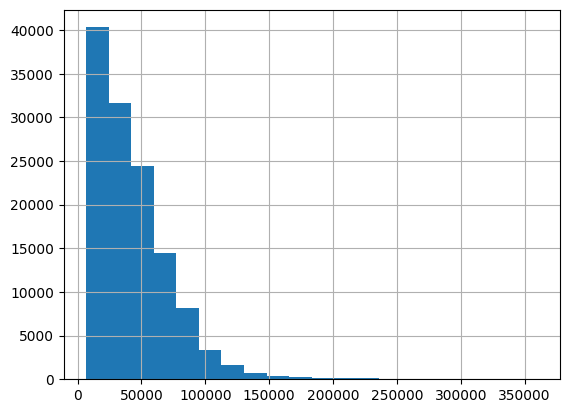

In [349]:
df_subm.price.hist(bins=20)

In [350]:
df_subm.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,price
0,188533,16993.527421
1,188534,76614.772806
2,188535,56346.728295
3,188536,30221.561183
4,188537,31085.601538
...,...,...
125685,314218,26665.571205
125686,314219,49782.653888
125687,314220,18555.085573
125688,314221,15593.494900
